In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.gridspec as gridspec
from pylab import *
from sklearn.feature_selection import f_regression, mutual_info_regression
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import xarray as xr

In [2]:
def draw_plot(pos, bp, offset,edge_color, fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color, linewidth = 1.2)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)
        
def cons_count_rever(df,var,count):
    df_copy = pd.concat([df,(df[var].notnull().astype(int)
            .groupby(df[var].isnull().astype(int).cumsum())
            .cumsum().to_frame(count))], axis=1)
    
    df_m24 = df_copy[df_copy['consec_count']>=24] 
    index_24 = df_copy[df_copy['consec_count']==24].index
    
    df_p24 = pd.DataFrame()
    for i in range(len(index_24)):
        z = df.loc[(index_24 - pd.Timedelta(23,unit='h')).strftime('%Y-%m-%d %X')[i] : 
                    index_24.strftime('%Y-%m-%d %X')[i]]
        df_p24 = df_p24.append(z, ignore_index=False)
    dates = pd.concat([df_m24, df_p24], axis=1).index
    
    df_fin = df[df.index.isin(dates)]

    return(df_fin)

def time_means(df):
    month = df.groupby(df.index.strftime('%m')).mean()
    hour = df.groupby(df.index.strftime('%H')).mean()
    return(month,hour)

def mut_info(slo, met):
    mi = []
    for col in met.columns:
        mi.append(mutual_info_regression(slo, met[col])[0])
    return(mi)

def cross_cor(slopes, met_data):
    correlations = []
    lags = []
    for var in met_data.columns:
        z = sm.tsa.stattools.ccf(slopes, met_data[var], adjusted=False)
        lag = np.argmax(np.abs(z))
        lags.append(lag)
        correlations.append(z[lag])
    return(correlations, lags)

def spe_corr(slopes, met_data):
    correlations = []
    ps = []
    for var in met_data.columns:
        z = stats.spearmanr(slopes,met_data[var])
        correlations.append(z[0])
        ps.append(z[1])
    return(correlations, ps)

def boxplot_data(var):
    df = pd.DataFrame(data = {'Neutral': met_ne_data[var], 
                              'Reversal': met_lo_data[var],
                              'Organized': met_hi_data[var]})

    df = df.melt(value_vars=['Neutral', 'Reversal', 'Organized'],
                 var_name='Conditions', value_name='Value', ignore_index=False)
    return(df)

def scatter_box(var, varname, nbin):
    df1 = pd.DataFrame(data = {'Slope': daymean_st['Slope']*100})
    df1['bins'] = pd.qcut(df1['Slope'], nbin, precision = 4)
    if var == 'OLR':
        df = pd.DataFrame(data = {varname: olr[var]*(-1)})
    elif var == 'TPW':
        df = pd.DataFrame(data = {varname: mimic[var]})
    elif var == 'CTop':
        df = pd.DataFrame(data = {varname: daymean_ctt[var]})
    else:
        df = pd.DataFrame(data = {varname: daymean_t[var]})

    df = df.melt(value_vars=[varname],
                 var_name='Conditions', value_name='Value', ignore_index=False)
    df['bins'] = df1['bins']
    del(df1)
    return(df)

def var_data(filename,path,var,varname):
    ds = xr.open_dataset(path+filename)
    if var == 'tpwGrid':
        value = np.array(ds[var]).flatten()
        fecha = [d.strftime('%Y-%m-%d %H:%M:%S') for d in pd.date_range('2016-10-01','2020-01-01', freq='1D')]
    elif var == 'tope':
        value = np.array(ds[var]).flatten()
        fecha = [d.strftime('%Y-%m-%d %H:%M:%S') for d in pd.date_range('2016-01-01','2019-12-31 23:00:00', 
                                                                        freq='1H')]
    else:
        value = np.array(ds[var][0:1461]).flatten()
        fecha = [d.strftime('%Y-%m-%d %H:%M:%S') for d in pd.date_range('2016-01-01','2019-12-31', freq='1D')]
    temp = pd.DataFrame(np.column_stack((fecha,value)),columns = ['Dates',varname])
    temp.to_csv(path+var+'_data.csv', index = False)
    del(temp)
    varia = pd.read_csv(path+var+'_data.csv', index_col=0, parse_dates = True)
    return(varia)

In [3]:
###Read Datasets and convert them!
#Path
latitud = '2-9' # 2-9 3-10 3S-4N 1p5S-8p5S
longitud = '135-145' # 135-145 147-157 156-166 163-173
path = '/Users/Casi94/Documents/PhD/Thesis/NN_real/Area_'+latitud+'_'+longitud+'_ERA5/'
#Data
slopes = pd.read_csv(path+'Slopes_data_ERA5.csv', parse_dates = True, index_col = 0)
met_data= pd.read_csv(path+'Complete_met_data.csv', parse_dates = True, index_col = 0)
met_data['CIN'] = met_data['CIN'].fillna(value=met_data['CIN'].mean())
utc = -9
slopes.index = slopes.index - pd.Timedelta(utc,unit='h')
met_data.index = met_data.index - pd.Timedelta(utc,unit='h')
### OLR from NOAA
olr = var_data('OLR_NOAA_fldmean.nc',path,'olr','OLR')
mimic = var_data('Mimic_fldmean.nc',path,'tpwGrid','TPW')
mimic['TPW'] = mimic['TPW'].fillna(value=mimic['TPW'].mean())
ctop = var_data('cloud_area.nc', path, 'tope', 'CTop')
ctop['CTop'] = ctop['CTop'].fillna(value=ctop['CTop'].mean())

## Select the dates for the reversals and organized states

Text(0, 0.5, 'Slope')

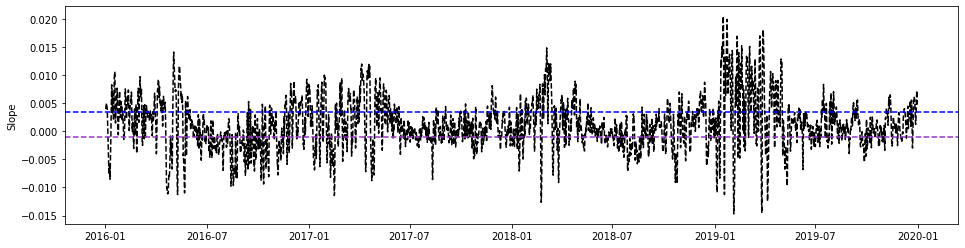

In [4]:
fac = 0.5
slopes_crit_lo=-fac*slopes.std()[0] # slopes_sd # critical threshold for an event
slopes_crit_hi=fac*slopes.std()[0] # slopes_sd # critical threshold for an event
slopes_mask_lo=slopes[slopes<slopes_crit_lo]
slopes_mask_hi=slopes[slopes>slopes_crit_hi]

plt.figure(figsize=(16,4))
plt.plot(slopes, color = 'k', linestyle = '--')
plt.axhline(slopes.mean()[0]+slopes_crit_hi, color = 'blue', linestyle='--')
plt.axhline(slopes.mean()[0]+slopes_crit_lo, color = 'darkorchid', linestyle='--')
plt.ylabel('Slope')

In [5]:
### Here we produce the counts and select the days with reversals and with organized states!!!
# First the states
df_slop_lo = cons_count_rever(slopes_mask_lo, 'Slope', 'consec_count')
df_slop_hi = cons_count_rever(slopes_mask_hi, 'Slope', 'consec_count')
df_slop_ne = pd.concat([slopes, df_slop_lo]).drop_duplicates(keep=False)
df_slop_ne = pd.concat([df_slop_ne, df_slop_hi]).drop_duplicates(keep=False)

#Second select those days in the meteorological data!
met_lo_data = met_data[met_data.index.isin(df_slop_lo.index)]
met_hi_data = met_data[met_data.index.isin(df_slop_hi.index)]
met_ne_data = pd.concat([met_data, met_lo_data]).drop_duplicates(keep=False)
met_ne_data = pd.concat([met_ne_data, met_hi_data]).drop_duplicates(keep=False)

## Lets first see some slopes means and lets compare their characteristics

In [6]:
###Slopes!
#Total
month_t_slo, hour_t_slo = time_means(slopes)
#Reversals
month_lo_slo, hour_lo_slo = time_means(df_slop_lo)
msize_lo_slo = df_slop_lo.groupby(df_slop_lo.index.strftime('%m')).size()/24 
#divided by 24, to prevent double counts
#Organized
month_hi_slo, hour_hi_slo = time_means(df_slop_hi)
msize_hi_slo = df_slop_hi.groupby(df_slop_hi.index.strftime('%h')).size()/24
#Neutral
month_ne_slo, hour_ne_slo = time_means(df_slop_ne)
msize_ne_slo = df_slop_ne.groupby(df_slop_ne.index.strftime('%h')).size()/24

In [7]:
###Meteorology data
#Total
month_t_met, hour_t_met = time_means(met_data)
#Reversals
month_lo_met, hour_lo_met = time_means(met_lo_data)
#Organized
month_hi_met, hour_hi_met = time_means(met_hi_data)
#Neutral
month_ne_met, hour_ne_met = time_means(met_ne_data)

## Meteorology

## Full data

## From hourly values

In [8]:
radiation = met_data.columns[3:7]
zonally = met_data.columns[18:34]
meridionally = met_data.columns[45:61]  #V11 is 500 hPa
pressure = [ 500,  550,  600,  650,  700,  750,  775,  800,  825,
             850,  875,  900,  925,  950,  975, 1000]

#100,  125,  150,  175,  200,  225,  250,  300,  350,  400, 450,

### Boxplot explanation!
https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

The minimum and maximum are the lines, the end of the boxes are the Q1 and Q3, and the dots are the outliers which are Q1 - 1.5 x IQR and Q3 + 1.5 x IQR

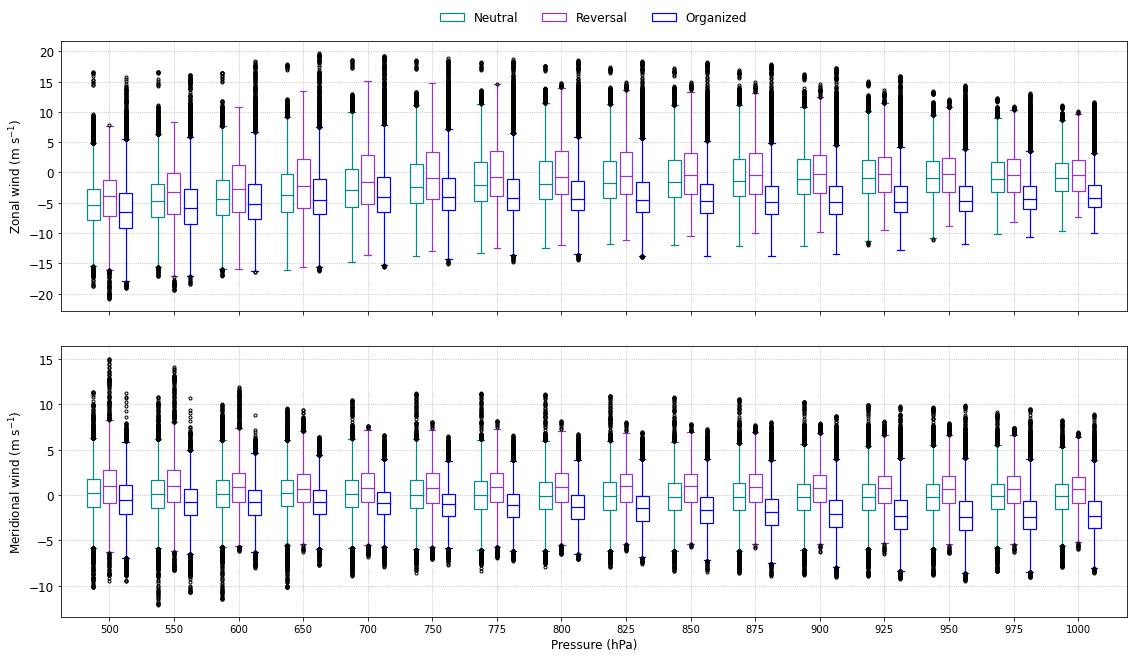

In [9]:
varis = [zonally, meridionally]
names = ['Zonal wind', 'Meridional wind']

fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(2,1, left=0.05, right=0.975, hspace=0.13, wspace=0.29, top=0.9, bottom=0.1)
sep = 0.25
width = 0.2

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    pos = np.arange(met_ne_data[var].shape[1])-sep
    bp = ax.boxplot(met_ne_data[var], positions= pos, widths=width, 
                    patch_artist=True, sym = '.')
    draw_plot(pos,bp,-sep, "darkcyan", "white")

    pos1 = np.arange(met_lo_data[var].shape[1])+0.0
    bp1 = ax.boxplot(met_lo_data[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

    pos2 = np.arange(met_hi_data[var].shape[1])+(sep)
    bp2 = ax.boxplot(met_hi_data[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+sep, "blue", "white")

    ax.set_xticks(pos1, pressure)
    plt.yticks(fontsize = 12)
    ax.set_ylabel(names[i]+' (m s$^{-1}$)', fontsize = 12)
    plt.grid(linestyle = ':')
    if i == 0:
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.legend([bp["boxes"][0],bp1["boxes"][0],bp2["boxes"][0]],['Neutral','Reversal','Organized'], 
              bbox_to_anchor = (0.5,1.15),loc = 'upper center', ncol = 3, frameon = False, fontsize = 12)
    else:
        ax.set_xlabel('Pressure (hPa)', fontsize = 12)
        

plt.savefig(path+'vertical_all_data_hor_wind_ne.jpg', bbox_inches='tight')
plt.show()

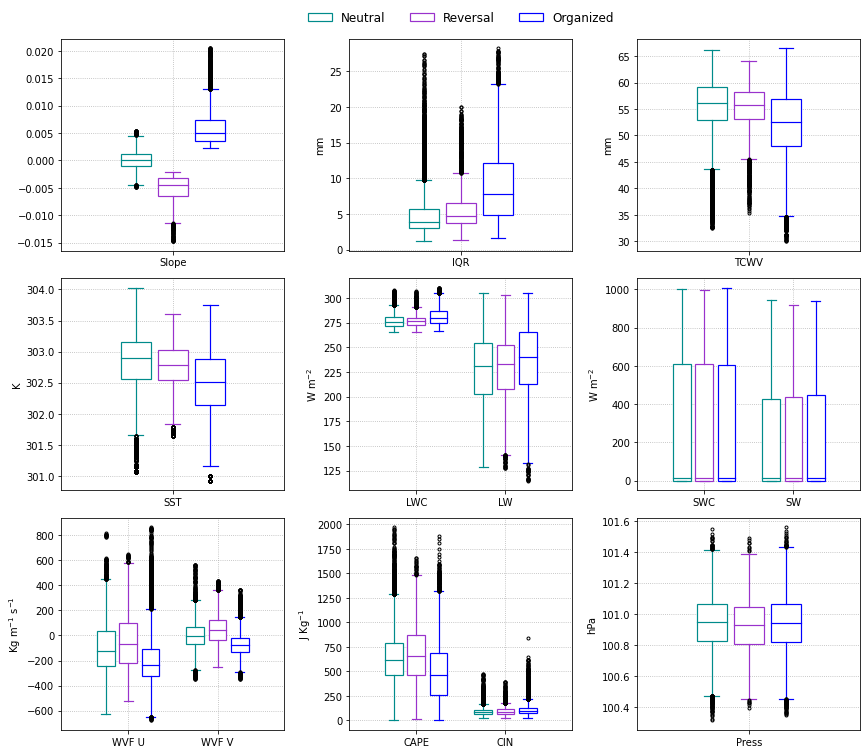

In [10]:
varis = [slopes.columns, met_data.columns[0:1], met_data.columns[2:3], met_data.columns[1:2], 
         met_data.columns[3:5], met_data.columns[5:7], met_data.columns[61:63], met_data.columns[63:65],
         met_data.columns[65:66]]

units = ['', 'mm', 'mm', 'K', 'W m$^{-2}$', 'W m$^{-2}$', 'Kg m$^{-1}$ s$^{-1}$', 'J Kg$^{-1}$', 'hPa']

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3,3, left=0.05, right=0.975, hspace=0.13, wspace=0.29, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    if i == 0:
        ###### Slopes
        pos = np.arange(df_slop_ne[var].shape[1])-sep
        bp = ax.boxplot(df_slop_ne[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(df_slop_lo[var].shape[1])+0.0
        bp1 = ax.boxplot(df_slop_lo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(df_slop_hi[var].shape[1])+(sep)
        bp2 = ax.boxplot(df_slop_hi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")
    else:
        pos = np.arange(met_ne_data[var].shape[1])-sep
        bp = ax.boxplot(met_ne_data[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(met_lo_data[var].shape[1])+0.0
        bp1 = ax.boxplot(met_lo_data[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(met_hi_data[var].shape[1])+(sep)
        bp2 = ax.boxplot(met_hi_data[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")
        
    if i == 1:
        ax.legend([bp["boxes"][0],bp1["boxes"][0],bp2["boxes"][0]],['Neutral','Reversal','Organized'], 
                   bbox_to_anchor = (0.5,1.18),loc = 'upper center', ncol = 3, 
                   frameon = False, fontsize = 12)

    ax.set_xticks(pos1, var)
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
plt.savefig(path+'all_data_met_ne.jpg', bbox_inches='tight')


## For every month

In [11]:
monmean_t = met_data.resample('M').mean().dropna()
monmean_lo = met_lo_data.resample('M').mean().dropna()
monmean_hi = met_hi_data.resample('M').mean().dropna()
monmean_ne = met_ne_data.resample('M').mean().dropna()

monmean_st = slopes.resample('M').mean().dropna()
monmean_slo = df_slop_lo.resample('M').mean().dropna()
monmean_shi = df_slop_hi.resample('M').mean().dropna()
monmean_sne = df_slop_ne.resample('M').mean().dropna()

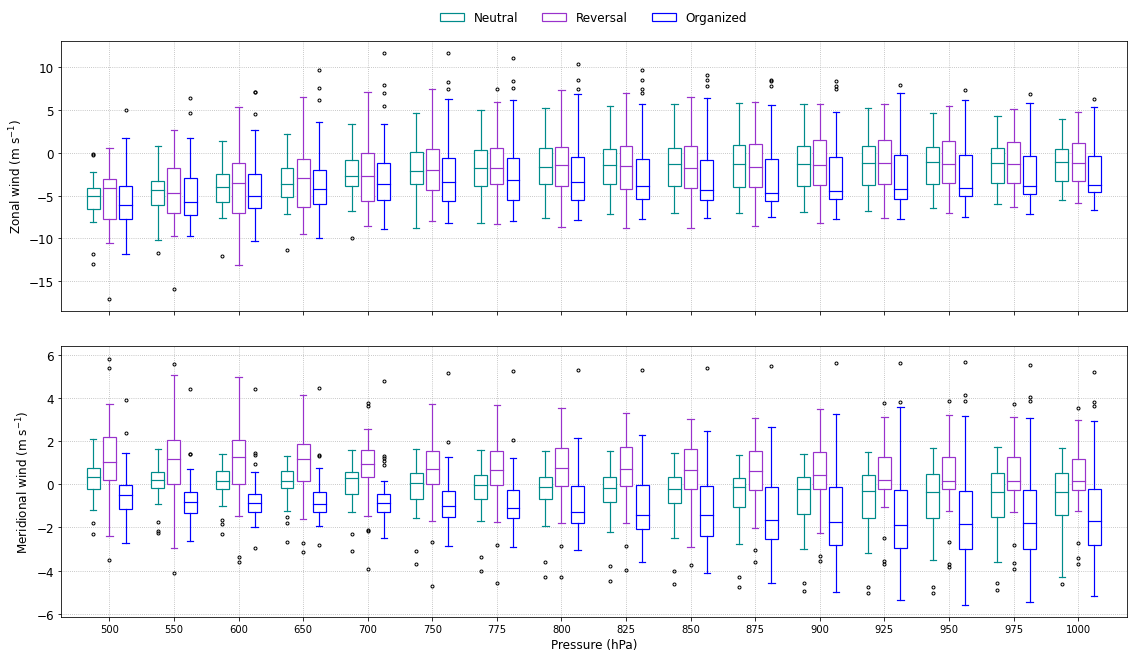

In [12]:
varis = [zonally, meridionally]
names = ['Zonal wind', 'Meridional wind']

fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(2,1, left=0.05, right=0.975, hspace=0.13, wspace=0.29, top=0.9, bottom=0.1)
sep = 0.25
width = 0.2

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    pos = np.arange(monmean_ne[var].shape[1])-sep
    bp = ax.boxplot(monmean_ne[var], positions= pos, widths=width, 
                    patch_artist=True, sym = '.')
    draw_plot(pos,bp,-sep, "darkcyan", "white")

    pos1 = np.arange(monmean_lo[var].shape[1])+0.0
    bp1 = ax.boxplot(monmean_lo[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

    pos2 = np.arange(monmean_hi[var].shape[1])+(sep)
    bp2 = ax.boxplot(monmean_hi[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+sep, "blue", "white")

    ax.set_xticks(pos1, pressure)
    plt.yticks(fontsize = 12)
    ax.set_ylabel(names[i]+' (m s$^{-1}$)', fontsize = 12)
    plt.grid(linestyle = ':')
    if i == 0:
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.legend([bp["boxes"][0],bp1["boxes"][0],bp2["boxes"][0]],['Neutral','Reversal','Organized'], 
              bbox_to_anchor = (0.5,1.15),loc = 'upper center', ncol = 3, frameon = False, fontsize = 12)
    else:
        ax.set_xlabel('Pressure (hPa)', fontsize = 12)

plt.savefig(path+'vertical_monthly_hor_wind_ne.jpg', bbox_inches='tight')
plt.show()

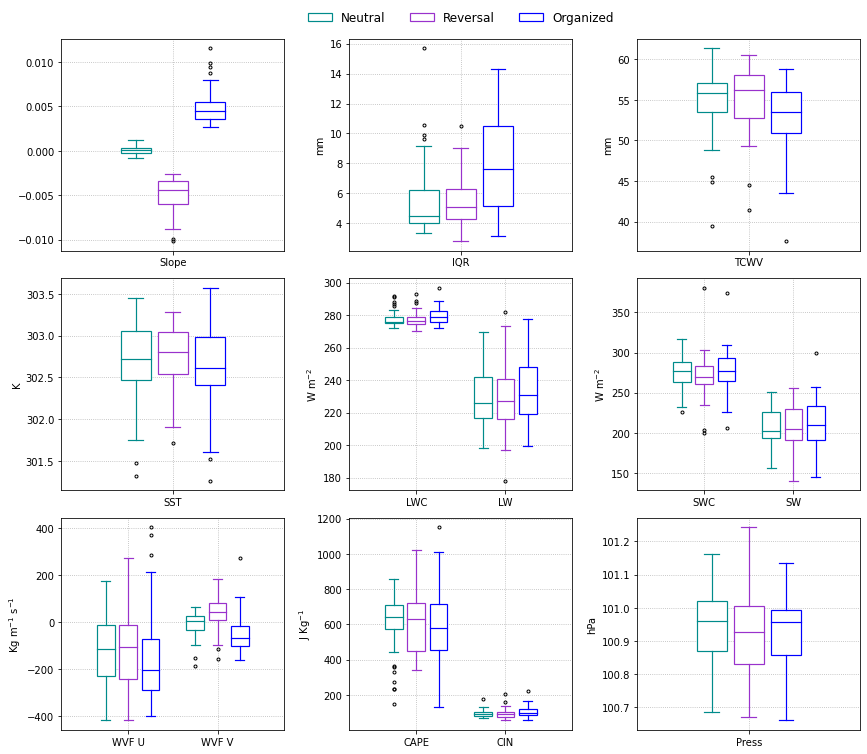

In [13]:
varis = [slopes.columns, met_data.columns[0:1], met_data.columns[2:3], met_data.columns[1:2], 
         met_data.columns[3:5], met_data.columns[5:7], met_data.columns[61:63], met_data.columns[63:65],
         met_data.columns[65:66]]

units = ['', 'mm', 'mm', 'K', 'W m$^{-2}$', 'W m$^{-2}$', 'Kg m$^{-1}$ s$^{-1}$', 'J Kg$^{-1}$', 'hPa']

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3,3, left=0.05, right=0.975, hspace=0.13, wspace=0.29, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    if i == 0:
        ###### Slopes
        pos = np.arange(monmean_sne[var].shape[1])-sep
        bp = ax.boxplot(monmean_sne[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(monmean_slo[var].shape[1])+0.0
        bp1 = ax.boxplot(monmean_slo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(monmean_shi[var].shape[1])+(sep)
        bp2 = ax.boxplot(monmean_shi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")
    else:
        pos = np.arange(monmean_ne[var].shape[1])-sep
        bp = ax.boxplot(monmean_ne[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(monmean_lo[var].shape[1])+0.0
        bp1 = ax.boxplot(monmean_lo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(monmean_hi[var].shape[1])+(sep)
        bp2 = ax.boxplot(monmean_hi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")
        
    if i == 1:
        ax.legend([bp["boxes"][0],bp1["boxes"][0],bp2["boxes"][0]],['Neutral','Reversal','Organized'], 
                   bbox_to_anchor = (0.5,1.18),loc = 'upper center', ncol = 3, 
                   frameon = False, fontsize = 12)

    ax.set_xticks(pos1, var)
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
plt.savefig(path+'monthly_met_ne.jpg', bbox_inches='tight')

## For every day

In [14]:
daymean_t = met_data.resample('D').mean().dropna()
daymean_lo = met_lo_data.resample('D').mean().dropna()
daymean_hi = met_hi_data.resample('D').mean().dropna()
daymean_ne = met_ne_data.resample('D').mean().dropna()

daymean_st = slopes.resample('D').mean().dropna()
daymean_slo = df_slop_lo.resample('D').mean().dropna()
daymean_shi = df_slop_hi.resample('D').mean().dropna()
daymean_sne = df_slop_ne.resample('D').mean().dropna()

#Clod TOP
daymean_ctt = ctop.resample('D').mean().dropna()
daymean_ctlo = daymean_ctt[daymean_ctt.index.isin(daymean_lo.index)]
daymean_cthi = daymean_ctt[daymean_ctt.index.isin(daymean_hi.index)]
daymean_ctne = daymean_ctt[daymean_ctt.index.isin(daymean_ne.index)]

#OLR
daymean_olo = olr[olr.index.isin(daymean_lo.index)]*(-1)
daymean_ohi = olr[olr.index.isin(daymean_hi.index)]*(-1)
daymean_one = olr[olr.index.isin(daymean_ne.index)]*(-1)

#MIMIC
daymean_pwlo = mimic[mimic.index.isin(daymean_lo.index)]
daymean_pwhi = mimic[mimic.index.isin(daymean_hi.index)]
daymean_pwne = mimic[mimic.index.isin(daymean_ne.index)]

### T-test

In [15]:
from scipy import stats
import os
varttest = list(daymean_ne.columns)
#varttest.append('OLR')
varttest.append('CTop')
#varttest.append('TPW')
p_val_hi = []
t_tes_hi = []
p_val_lo = [] 
t_tes_lo = []
p_val_lh = []
t_tes_lh = []

columnas = ['Variables','Org ttest','Org p-value','Rev ttest','Rev p-value', 'Org-Rev ttest', 'Org-Rev p-value']

for var in varttest:
    if var == 'OLR':
        hi = stats.ttest_ind(np.array(daymean_one[var]), np.array(daymean_ohi[var]), equal_var = False)
        lo = stats.ttest_ind(np.array(daymean_one[var]), np.array(daymean_olo[var]), equal_var = False)
        lh = stats.ttest_ind(np.array(daymean_ohi[var]), np.array(daymean_olo[var]), equal_var = False)
    elif var == 'CTop':
        hi = stats.ttest_ind(np.array(daymean_ctne[var]), np.array(daymean_cthi[var]), equal_var = False)
        lo = stats.ttest_ind(np.array(daymean_ctne[var]), np.array(daymean_ctlo[var]), equal_var = False)
        lh = stats.ttest_ind(np.array(daymean_cthi[var]), np.array(daymean_ctlo[var]), equal_var = False)
    elif var == 'TPW':
        hi = stats.ttest_ind(np.array(daymean_pwne[var]), np.array(daymean_pwhi[var]), equal_var = False)
        lo = stats.ttest_ind(np.array(daymean_pwne[var]), np.array(daymean_pwlo[var]), equal_var = False)
        lh = stats.ttest_ind(np.array(daymean_pwhi[var]), np.array(daymean_pwlo[var]), equal_var = False)
    else:
        hi = stats.ttest_ind(np.array(daymean_ne[var]), np.array(daymean_hi[var]), equal_var = False)
        lo = stats.ttest_ind(np.array(daymean_ne[var]), np.array(daymean_lo[var]), equal_var = False)
        lh = stats.ttest_ind(np.array(daymean_hi[var]), np.array(daymean_lo[var]), equal_var = False)
    t_tes_hi.append(hi[0])
    t_tes_lo.append(lo[0])
    t_tes_lh.append(lh[0])
    p_val_hi.append(hi[1])
    p_val_lo.append(lo[1])
    p_val_lh.append(lh[1])
    
data = pd.DataFrame(np.column_stack((varttest,t_tes_hi,p_val_hi,t_tes_lo,p_val_lo,t_tes_lh,p_val_lh)), 
                    columns = columnas)
data.to_csv(path+'ttest.csv')
data = pd.read_csv(path+'ttest.csv')

org_sig = data.where(data['Org p-value'] < 0.005)
rev_sig = data.where(data['Rev p-value'] < 0.005)
org_rev_sig = data.where(data['Org-Rev p-value'] < 0.005)

vartfig = list(daymean_ne.columns)
vartfig.append('OLR')
vartfig.append('CFrac')
vartfig.append('TPW')

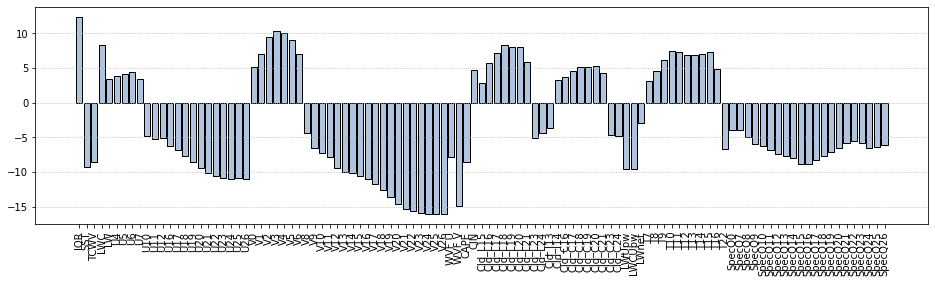

In [16]:
test = org_sig[org_sig['Org-Rev p-value'] < 0.005]
plt.figure(figsize=(16,4))
plt.bar(test['Variables'],test['Org-Rev ttest'], color = 'lightsteelblue', edgecolor='k')
plt.xticks(rotation=90)
plt.grid(linestyle=':',axis='y')
plt.show()

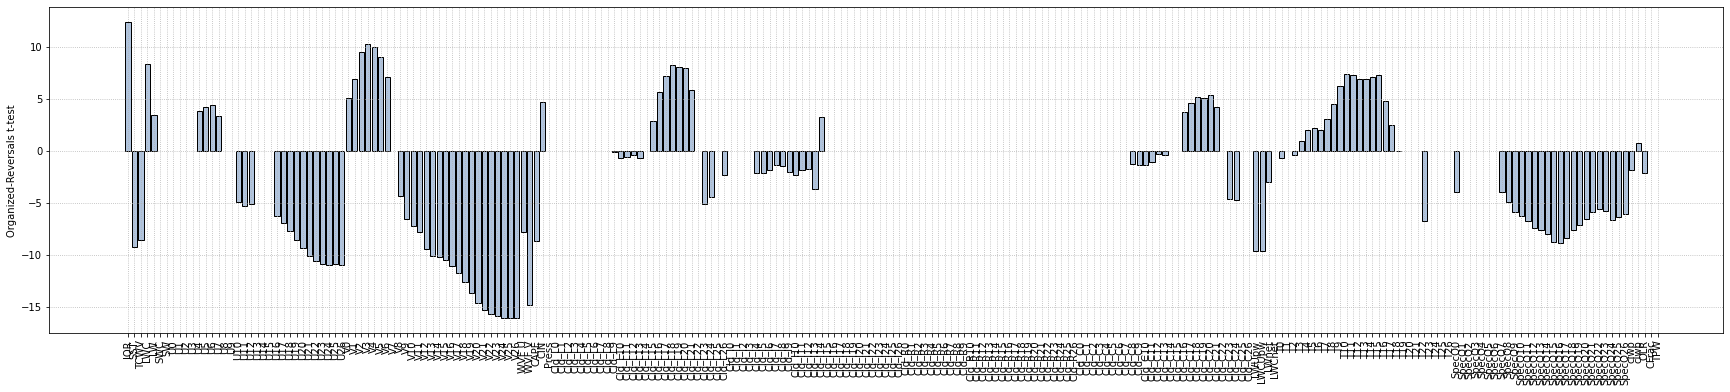

In [17]:
plt.figure(figsize = (30,6))
plt.bar(np.arange(0,len(org_sig['Org-Rev ttest'])),np.array(org_sig['Org-Rev ttest']), 
        edgecolor = 'k', color = 'lightsteelblue')
plt.xticks(np.arange(0,len(vartfig)), vartfig, rotation = 90)
plt.ylabel('Organized-Reversals t-test')
plt.grid(linestyle=':')
plt.savefig(path+'ttest_org-rev.jpg', bbox_inches='tight')
plt.show()

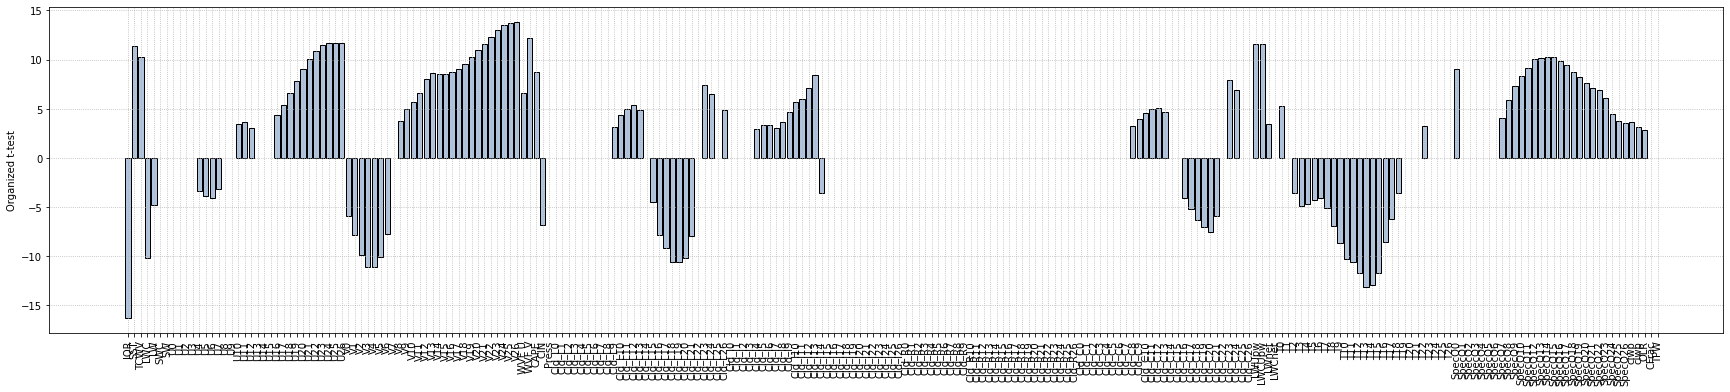

In [18]:
plt.figure(figsize = (30,6))
plt.bar(np.arange(0,len(org_sig['Org ttest'])),np.array(org_sig['Org ttest']), 
        edgecolor = 'k', color = 'lightsteelblue')
plt.xticks(np.arange(0,len(vartfig)), vartfig, rotation = 90)
plt.grid(linestyle=':')
plt.ylabel('Organized t-test')
plt.show()

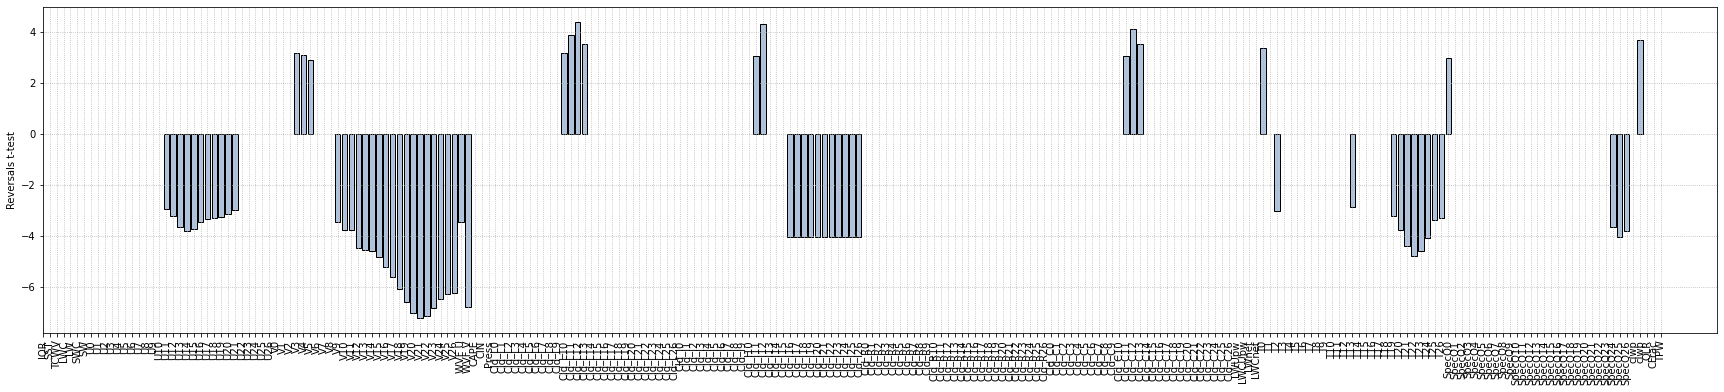

In [19]:
plt.figure(figsize = (30,6))
plt.bar(np.arange(0,len(org_sig['Rev ttest'])),np.array(rev_sig['Rev ttest']), 
        edgecolor = 'k', color = 'lightsteelblue')
plt.xticks(np.arange(0,len(vartfig)), vartfig, rotation = 90)
plt.grid(linestyle=':')
plt.ylabel('Reversals t-test')
plt.show()

## Cloud fraction PDF

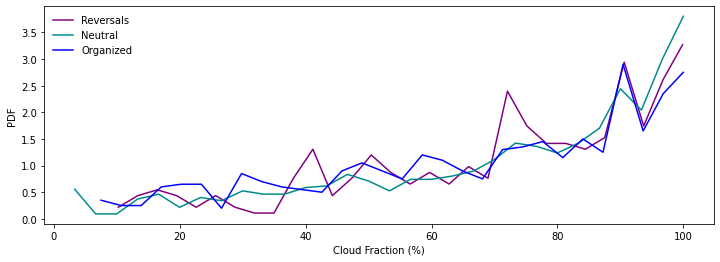

In [20]:
n_bins = 30
pdf_hi, bin_edges_hi = np.histogram(daymean_cthi['CTop'], bins = n_bins, density = True)
pdf_lo, bin_edges_lo = np.histogram(daymean_ctlo['CTop'], bins = n_bins, density = True)
pdf_ne, bin_edges_ne = np.histogram(daymean_ctne['CTop'], bins = n_bins, density = True)

plt.figure(figsize=(12,4))
plt.plot(bin_edges_lo[1:]*100, pdf_lo, color = 'purple', label = 'Reversals')
plt.plot(bin_edges_ne[1:]*100, pdf_ne, color = 'darkcyan', label = 'Neutral')
plt.plot(bin_edges_hi[1:]*100, pdf_hi, color = 'blue', label = 'Organized')
plt.legend(frameon=False)
plt.xlabel('Cloud Fraction (%)')
plt.ylabel('PDF')
plt.savefig(path+'Cloud_fraction.jpg', bbox_inches='tight')

In [21]:
ds_tot =  xr.open_dataset(path+'Cld_TOP_area.nc')
ctop_lo = ds_tot.sel(time=daymean_lo.index)
ctop_lo = np.array(ctop_lo.tope).flatten()
ctop_lo = ctop_lo[ctop_lo>0]
ctop_lo = ctop_lo[~np.isnan(ctop_lo)]
ctop_ne = ds_tot.sel(time=daymean_ne.index)
ctop_ne = np.array(ctop_ne.tope).flatten()
ctop_ne = ctop_ne[ctop_ne>0]
ctop_ne = ctop_ne[~np.isnan(ctop_ne)]
ctop_hi = ds_tot.sel(time=daymean_hi.index)
ctop_hi = np.array(ctop_hi.tope).flatten()
ctop_hi = ctop_hi[ctop_hi>0]
ctop_hi = ctop_hi[~np.isnan(ctop_hi)]
del(ds_tot)

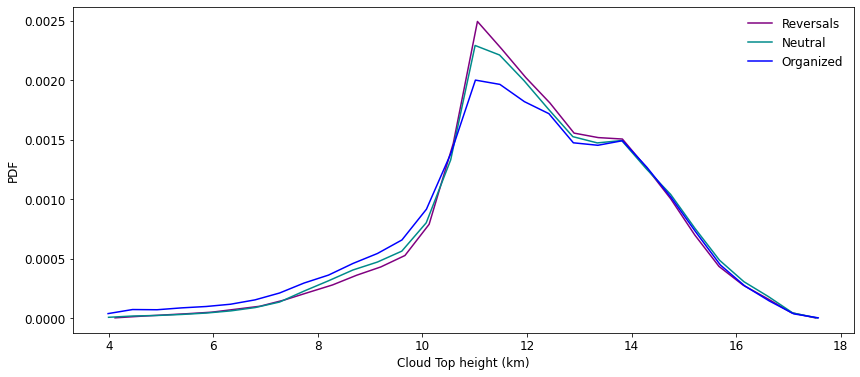

In [22]:
pdf_hi_ct, bin_edges_hi_ct = np.histogram(ctop_hi, bins = n_bins, density = True)
pdf_lo_ct, bin_edges_lo_ct = np.histogram(ctop_lo, bins = n_bins, density = True)
pdf_ne_ct, bin_edges_ne_ct = np.histogram(ctop_ne, bins = n_bins, density = True)

plt.figure(figsize=(14,6))
plt.plot(bin_edges_lo_ct[1:]/100, pdf_lo_ct, color = 'purple', label = 'Reversals')
plt.plot(bin_edges_ne_ct[1:]/100, pdf_ne_ct, color = 'darkcyan', label = 'Neutral')
plt.plot(bin_edges_hi_ct[1:]/100, pdf_hi_ct, color = 'blue', label = 'Organized')
plt.xlabel('Cloud Top height (km)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('PDF', fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(frameon = False, fontsize = 12)
plt.savefig(path+'pdf_CTOP.jpg', bbox_inches='tight')
plt.show()

## Scatter plot

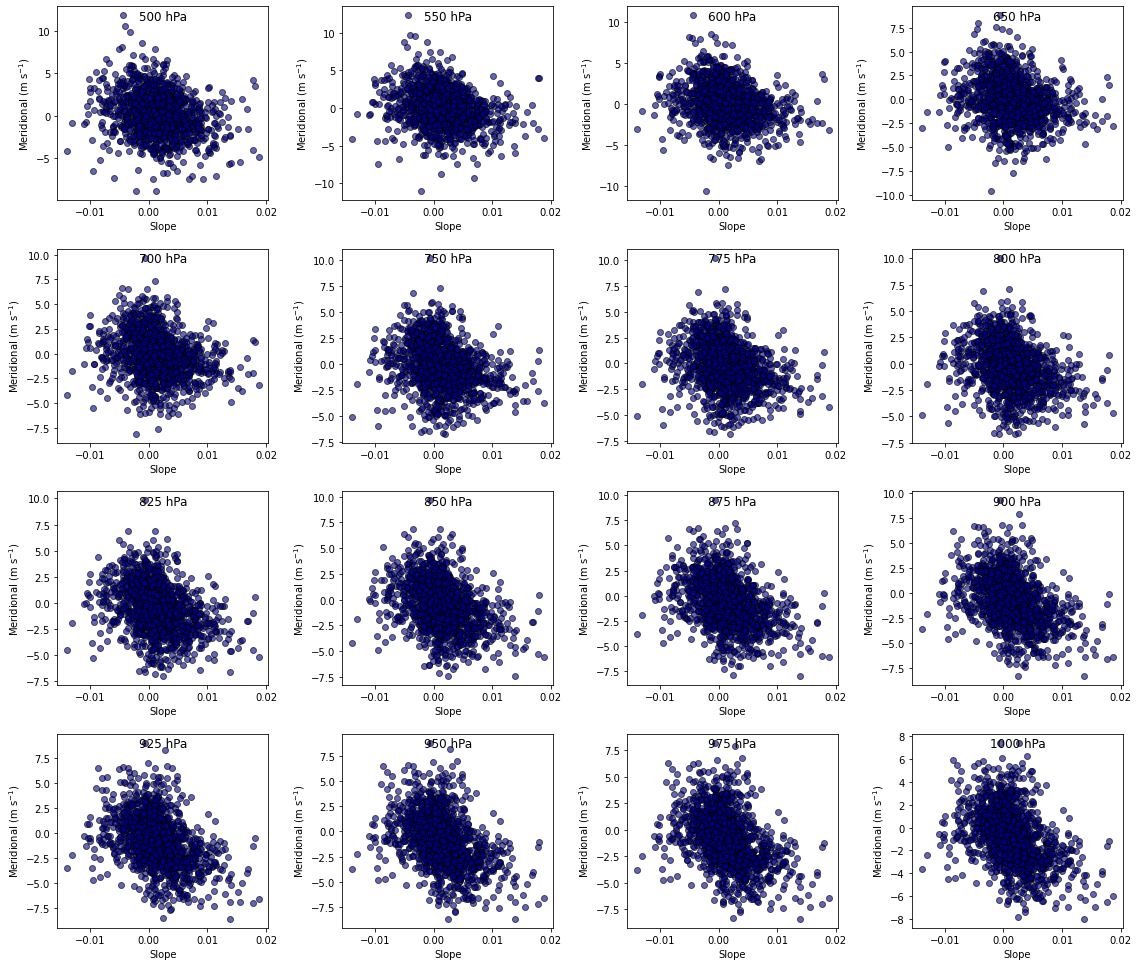

In [23]:
pp = pressure
fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(4,4, left=0.05, right=0.975, hspace=0.25, wspace=0.35, top=0.9, bottom=0.1)

for i,var in enumerate(meridionally):
    ax=subplot(gs[i])
    plt.scatter(daymean_st['Slope'], daymean_t[var], color = 'darkblue', alpha = 0.6, edgecolor = 'k')
    #plt.scatter(daymean_slo['Slope'], daymean_lo[var], color = 'darkorchid', s = 6, alpha = 0.6)
    #plt.scatter(daymean_shi['Slope'], daymean_hi[var], color = 'blue', s = 5, alpha = 0.6)
    plt.ylabel('Meridional (m s$^{-1}$)')
    plt.xlabel('Slope')
    plt.title(str(pp[i])+' hPa', y = 0.9)
plt.savefig(path+'Meridional_scatter.jpg', bbox_inches='tight')

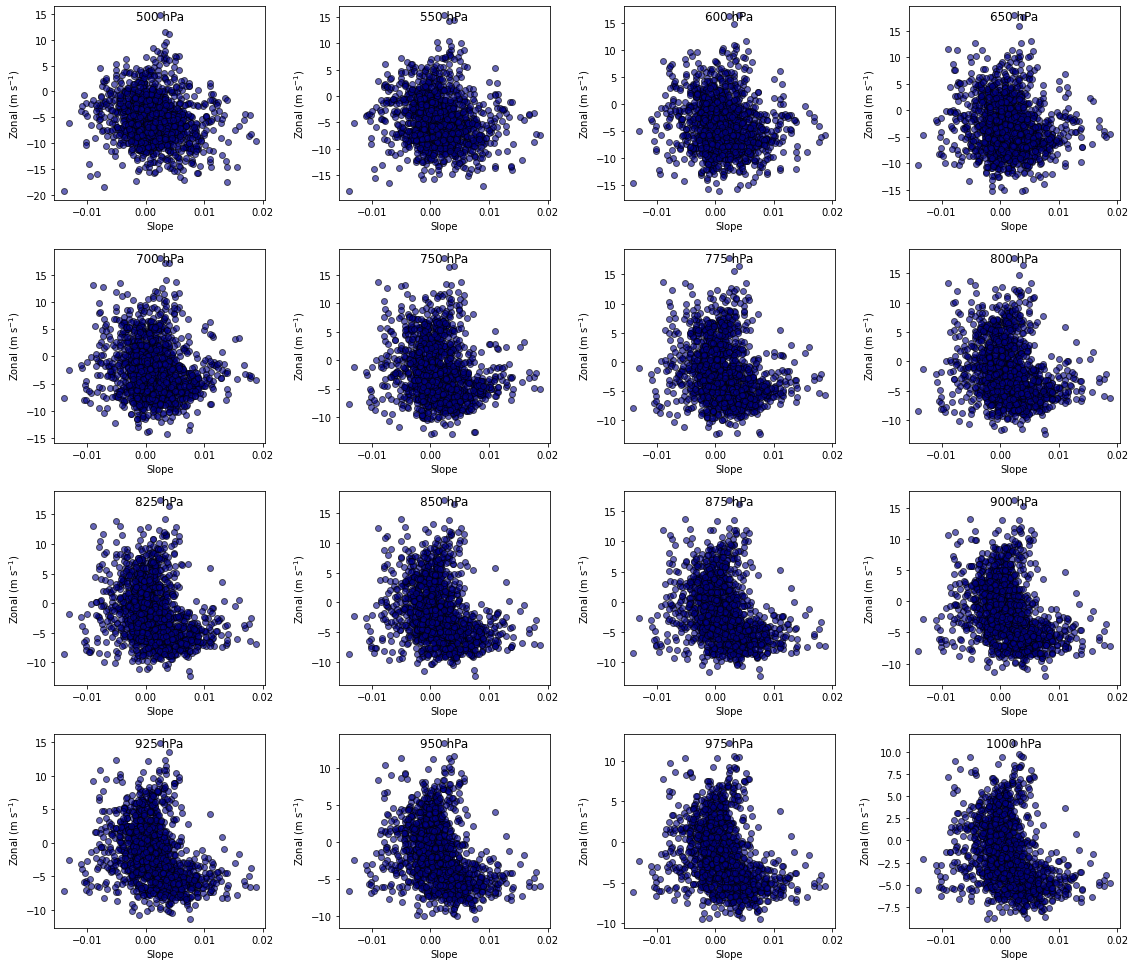

In [24]:
fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(4,4, left=0.05, right=0.975, hspace=0.25, wspace=0.35, top=0.9, bottom=0.1)

for i,var in enumerate(zonally):
    ax=subplot(gs[i])
    plt.scatter(daymean_st['Slope'], daymean_t[var], color = 'darkblue', alpha = 0.6, edgecolor = 'k')
    #plt.scatter(daymean_slo['Slope'], daymean_lo[var], color = 'darkorchid', s = 6, alpha = 0.6)
    #plt.scatter(daymean_shi['Slope'], daymean_hi[var], color = 'blue', s = 5, alpha = 0.6)
    plt.ylabel('Zonal (m s$^{-1}$)')
    plt.xlabel('Slope')
    plt.title(str(pp[i])+' hPa', y = 0.9)
plt.savefig(path+'Zonal_scatter.jpg', bbox_inches='tight')

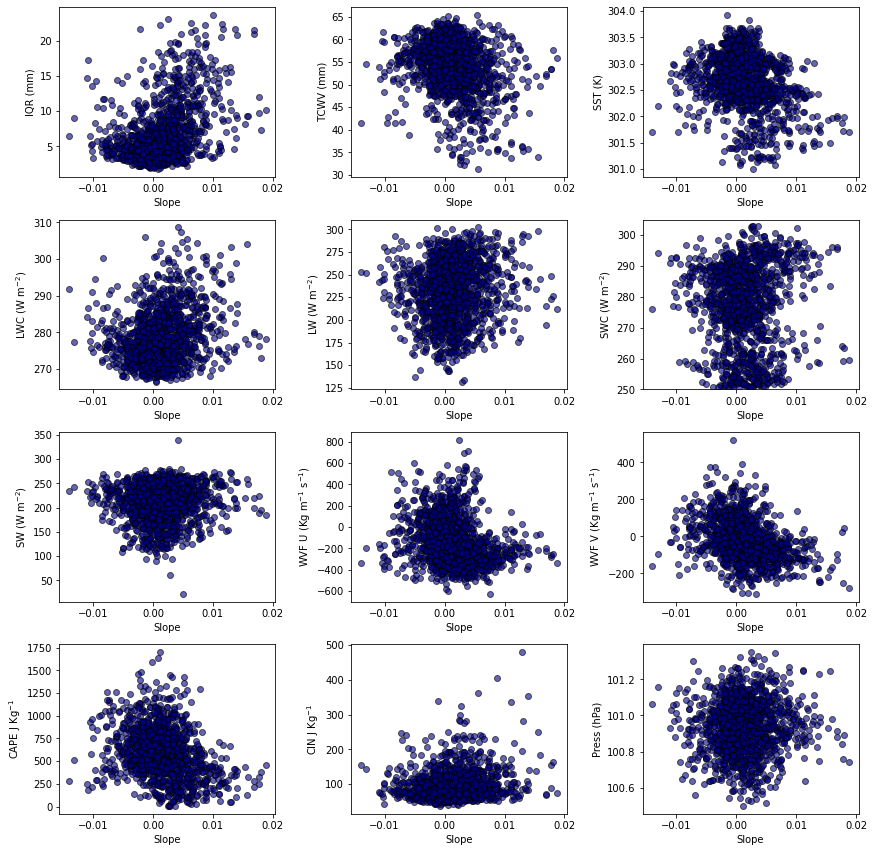

In [25]:
varis = [met_data.columns[0:1], met_data.columns[2:3], met_data.columns[1:2], 
         met_data.columns[3:4], met_data.columns[4:5], met_data.columns[5:6], 
         met_data.columns[6:7], met_data.columns[61:62], met_data.columns[62:63],
         met_data.columns[63:64], met_data.columns[64:65], met_data.columns[65:66]]

units = ['IQR (mm)', ' TCWV (mm)', 'SST (K)', 'LWC (W m$^{-2}$)', 
         'LW (W m$^{-2}$)', 'SWC (W m$^{-2}$)', 'SW (W m$^{-2}$)',
         'WVF U (Kg m$^{-1}$ s$^{-1}$)', 'WVF V (Kg m$^{-1}$ s$^{-1}$)', 
         'CAPE J Kg$^{-1}$','CIN J Kg$^{-1}$','Press (hPa)']

fig = plt.figure(figsize=(12,14))
gs = gridspec.GridSpec(4,3, left=0.05, right=0.975, hspace=0.25, wspace=0.35, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    plt.scatter(daymean_st['Slope'], daymean_t[var], color = 'darkblue', alpha = 0.6, edgecolor = 'k')
    #plt.scatter(daymean_slo['Slope'], daymean_lo[var], color = 'darkorchid', s = 6, alpha = 0.6)
    #plt.scatter(daymean_shi['Slope'], daymean_hi[var], color = 'blue', s = 5, alpha = 0.6)
    plt.ylabel(units[i])
    plt.xlabel('Slope')
    if var == 'SWC':
        plt.ylim(250,305)
plt.savefig(path+'Met_scatter.jpg', bbox_inches='tight')

### Scatter box!

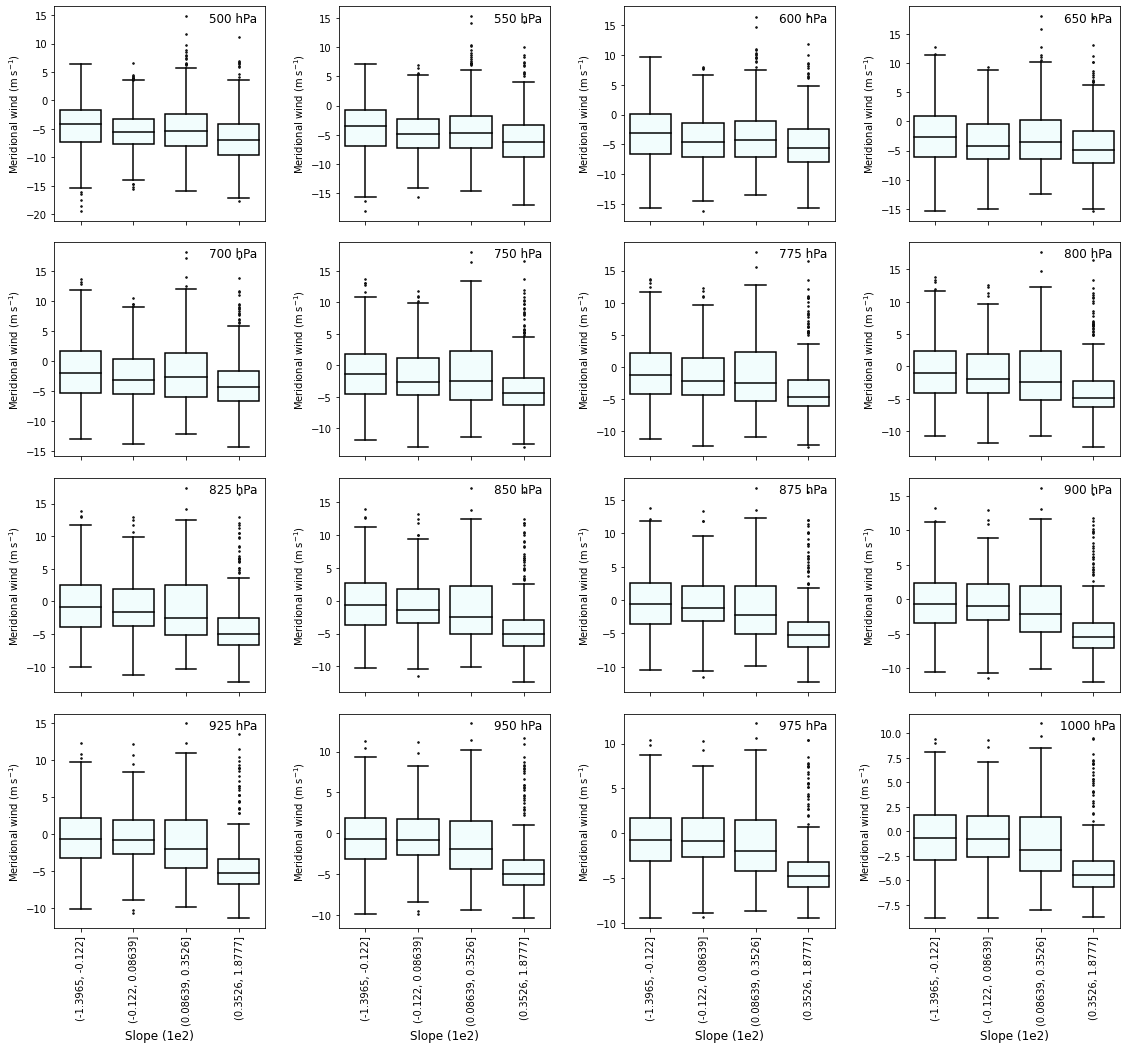

In [26]:
fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(4,4, left=0.05, right=0.975, hspace=0.1, wspace=0.35, top=0.9, bottom=0.1)

for i,var in enumerate(zonally):
    df = scatter_box(var, meridionally[i], 4)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x='bins', y='Value', hue='Conditions', palette=['azure'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    #plt.xticks(np.arange(0,13), fontsize = 12)
    if i < 12:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Slope (1e2)', fontsize = 12)
        plt.xticks(rotation=90)
    plt.title(str(pp[i])+' hPa', fontsize = 12, y = 0.9, x = 0.85)
    plt.ylabel('Meridional wind (m s$^{-1}$)')
    plt.legend('', frameon = False)
plt.savefig(path+'Meridional_scatter_box.jpg', bbox_inches='tight')

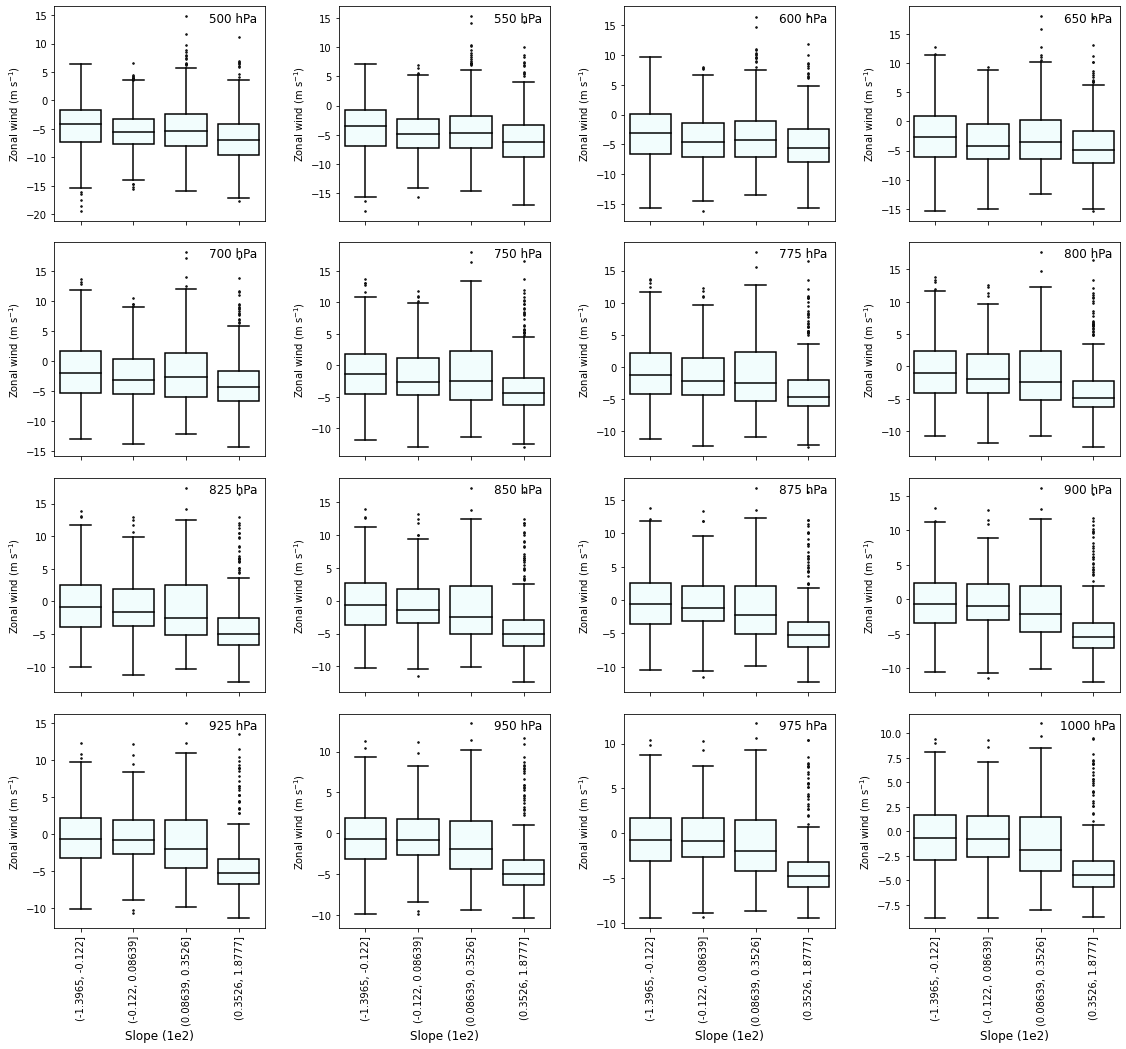

In [27]:
fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(4,4, left=0.05, right=0.975, hspace=0.1, wspace=0.35, top=0.9, bottom=0.1)

for i,var in enumerate(zonally):
    df = scatter_box(var, zonally[i], 4)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x='bins', y='Value', hue='Conditions', palette=['azure'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    #plt.xticks(np.arange(0,13), fontsize = 12)
    if i < 12:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Slope (1e2)', fontsize = 12)
        plt.xticks(rotation=90)
    plt.title(str(pp[i])+' hPa', fontsize = 12, y = 0.9, x = 0.85)
    plt.ylabel('Zonal wind (m s$^{-1}$)')
    plt.legend('', frameon = False)
plt.savefig(path+'Zonal_scatter_box.jpg', bbox_inches='tight')

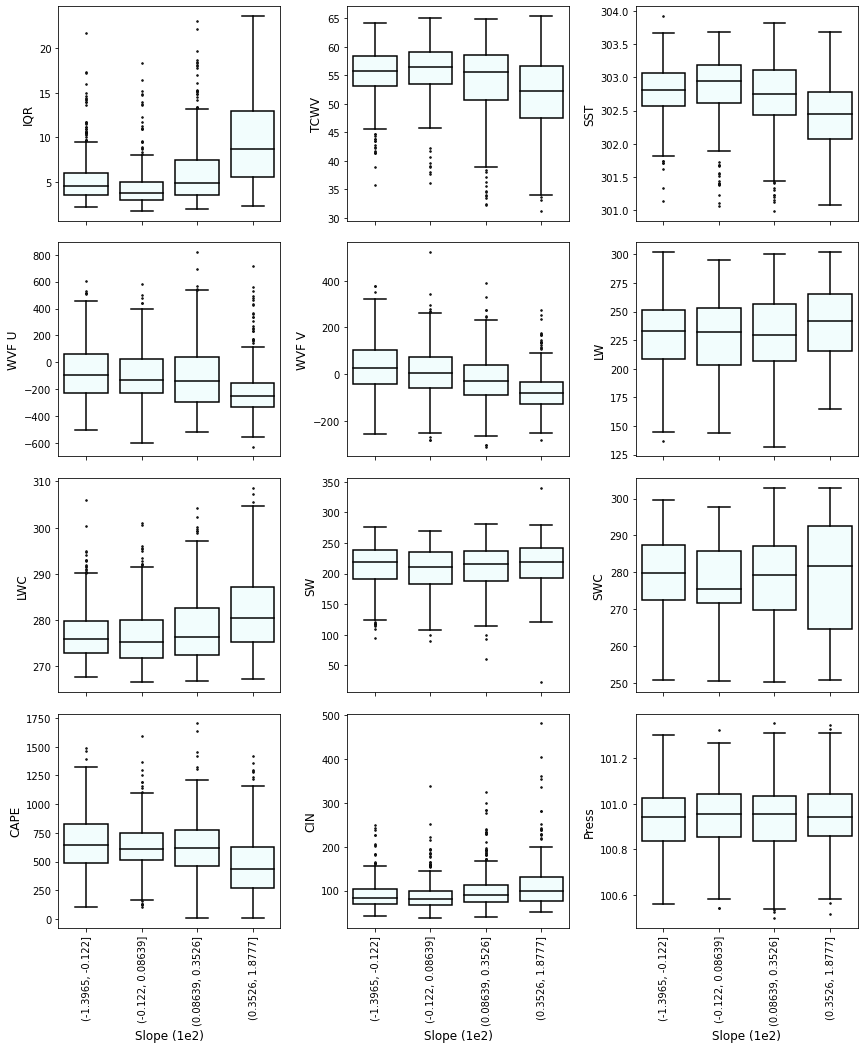

In [28]:
varis = ['IQR','TCWV','SST','WVF U','WVF V','LW','LWC','SW','SWC','CAPE','CIN','Press']
varname = ['IQR','TCWV','SST','WVF U','WVF V', 'LW','LWC','SW','SWC','CAPE','CIN','Press']

fig = plt.figure(figsize=(12,16))
gs = gridspec.GridSpec(4,3, left=0.05, right=0.975, hspace=0.1, wspace=0.3, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = scatter_box(var, varname[i], 4)
    ax=subplot(gs[i])
    if var != 'SWC':
        bp = sns.boxplot(data = df, x='bins', y='Value', hue='Conditions', palette=['azure'],
                         flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                         boxprops = dict(edgecolor='black'),
                         medianprops = dict(color = 'black'),
                         whiskerprops = dict(color = 'black'),
                         capprops = dict(color = 'black')
                        )
    else:
        bp = sns.boxplot(data = df, x='bins', y='Value', hue='Conditions', palette=['azure'],
                         flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                         boxprops = dict(edgecolor='black'),
                         medianprops = dict(color = 'black'),
                         whiskerprops = dict(color = 'black'),
                         capprops = dict(color = 'black'), showfliers= False
                        )

    #plt.xticks(np.arange(0,13), fontsize = 12)
    if i < 9:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Slope (1e2)', fontsize = 12)
        plt.xticks(rotation=90)
    #plt.axvline(daymean_st.mean()[0]*100 + slopes_crit_hi*100 + 2, color = 'b', linestyle = '--', linewidth = 0.7)
    #plt.axvline(daymean_st.mean()[0]*100 + slopes_crit_lo*100, color = 'darkorchid', 
    #            linestyle = '--', linewidth = 0.7)
    plt.ylabel(varname[i], fontsize = 12)
    plt.legend('', frameon = False)
plt.savefig(path+'Met_scatter_box.jpg', bbox_inches='tight')

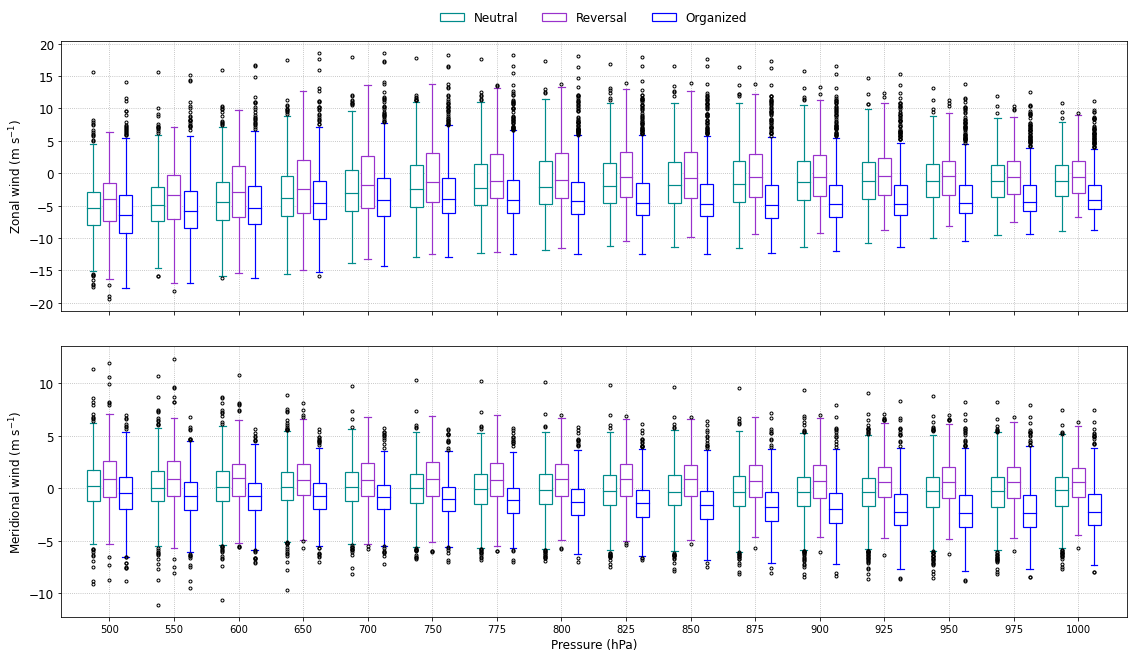

In [29]:
varis = [zonally, meridionally]
names = ['Zonal wind', 'Meridional wind']

fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(2,1, left=0.05, right=0.975, hspace=0.13, wspace=0.29, top=0.9, bottom=0.1)
sep = 0.25
width = 0.2

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    pos = np.arange(daymean_ne[var].shape[1])-sep
    bp = ax.boxplot(daymean_ne[var], positions= pos, widths=width, 
                    patch_artist=True, sym = '.')
    draw_plot(pos,bp,-sep, "darkcyan", "white")

    pos1 = np.arange(daymean_lo[var].shape[1])+0.0
    bp1 = ax.boxplot(daymean_lo[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

    pos2 = np.arange(daymean_hi[var].shape[1])+(sep)
    bp2 = ax.boxplot(daymean_hi[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+sep, "blue", "white")

    ax.set_xticks(pos1, pressure)
    plt.yticks(fontsize = 12)
    ax.set_ylabel(names[i]+' (m s$^{-1}$)', fontsize = 12)
    plt.grid(linestyle = ':')
    if i == 0:
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.legend([bp["boxes"][0],bp1["boxes"][0],bp2["boxes"][0]],['Neutral','Reversal','Organized'], 
              bbox_to_anchor = (0.5,1.15),loc = 'upper center', ncol = 3, frameon = False, fontsize = 12)
    else:
        ax.set_xlabel('Pressure (hPa)', fontsize = 12)

plt.savefig(path+'daily_ne.jpg', bbox_inches='tight')

plt.show()

# Clouds!

In [30]:
liq = met_data.columns[66:93]
ice = met_data.columns[93:120]
rain = met_data.columns[120:147]
cover = met_data.columns[147:174]

press_long = [ 100,  125,  150,  175,  200,  225,  250,  300,  350,  400, 450,
             500,  550,  600,  650,  700,  750,  775,  800,  825,  850,  875,  
             900,  925,  950,  975, 1000]

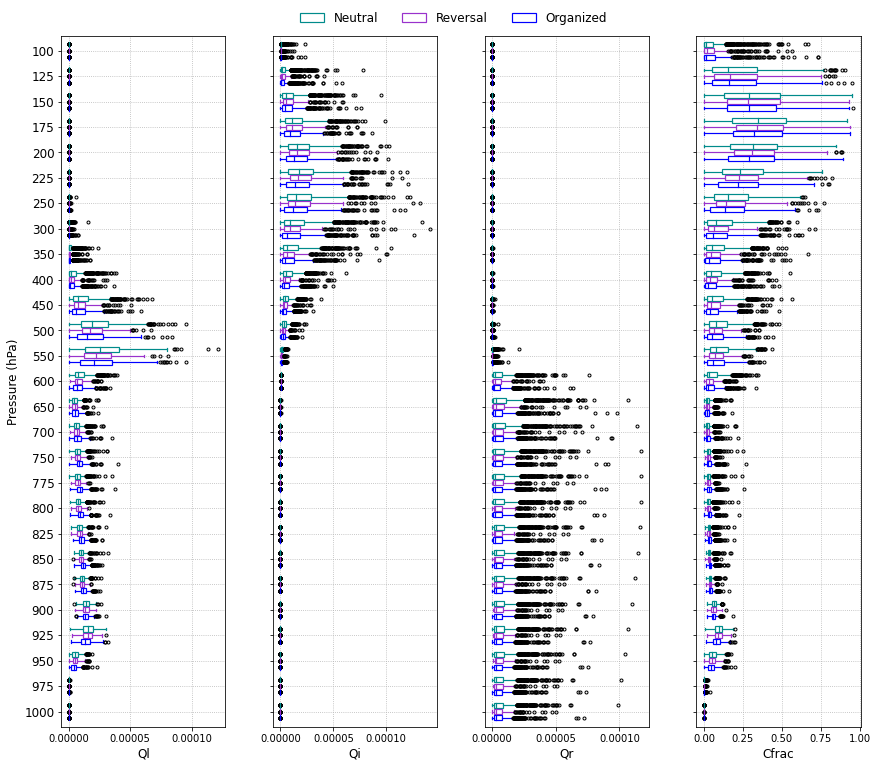

In [31]:
varis = [liq, ice, rain, cover]
names = ['Ql', 'Qi', 'Qr', 'Cfrac']

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(1,4, left=0.05, right=0.975, hspace=0.13, wspace=0.29, top=0.9, bottom=0.1)
sep = 0.25
width = 0.2

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    pos = np.arange(daymean_ne[var].shape[1])-sep
    bp = ax.boxplot(daymean_ne[var], positions= pos, widths=width, 
                    patch_artist=True, sym = '.', vert=False)
    draw_plot(pos,bp,-sep, "darkcyan", "white")

    pos1 = np.arange(daymean_lo[var].shape[1])+0.0
    bp1 = ax.boxplot(daymean_lo[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.',vert=False)
    draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

    pos2 = np.arange(daymean_hi[var].shape[1])+(sep)
    bp2 = ax.boxplot(daymean_hi[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos2,bp2,+sep, "blue", "white")

    ax.set_yticks(pos1, press_long)
    plt.yticks(fontsize = 12)
    plt.ylim(26.6,-0.6)
    ax.set_xlabel(names[i], fontsize = 12)
    plt.grid(linestyle = ':')
    if i == 0:
        ax.set_ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
    if i == 1:
        ax.legend([bp["boxes"][0],bp1["boxes"][0],bp2["boxes"][0]],['Neutral','Reversal','Organized'], 
              bbox_to_anchor = (1.1,1.05),loc = 'upper center', ncol = 3, frameon = False, fontsize = 12)

plt.savefig(path+'daily_ne_clouds.jpg', bbox_inches='tight')

plt.show()

In [32]:
def clouds_means(data, spe):
    lista = []
    for i,var in enumerate(spe):
        lista.append(data[var].mean())
    return(lista)

In [33]:
liq_lo = clouds_means(daymean_lo, liq)
ice_lo = clouds_means(daymean_lo, ice)
rain_lo = clouds_means(daymean_lo, rain)
cfrac_lo = clouds_means(daymean_lo, cover)

liq_hi = clouds_means(daymean_hi, liq)
ice_hi = clouds_means(daymean_hi, ice)
rain_hi = clouds_means(daymean_hi, rain)
cfrac_hi = clouds_means(daymean_hi, cover)

liq_ne = clouds_means(daymean_ne, liq)
ice_ne = clouds_means(daymean_ne, ice)
rain_ne = clouds_means(daymean_ne, rain)
cfrac_ne = clouds_means(daymean_ne, cover)

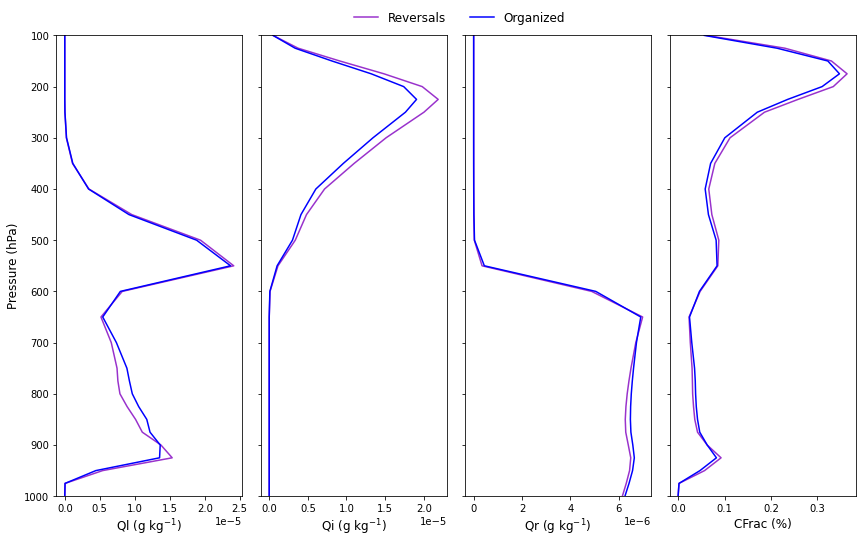

In [34]:
var_lo = [liq_lo, ice_lo, rain_lo, cfrac_lo]
var_hi = [liq_hi, ice_hi, rain_hi, cfrac_hi]
var_ne = [liq_ne, ice_ne, rain_ne, cfrac_ne]

title = ['Ql (g kg$^{-1}$)', 'Qi (g kg$^{-1}$)', 'Qr (g kg$^{-1}$)', 'CFrac (%)']

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(1,4, left=0.05, right=0.975, hspace=0.13, wspace=0.1, top=0.9, bottom=0.1)

for i,var in enumerate(var_lo):
    ax=subplot(gs[i])
    plt.plot(var, press_long, label = 'Reversals', color = 'darkorchid')
    #plt.plot(var_ne[i], press_long, label = 'Neutral', color = 'darkcyan')
    plt.plot(var_hi[i], press_long, label = 'Organized', color = 'blue')
    plt.ylim(1000,100)
    plt.xlabel(title[i], fontsize = 12)
    if i == 1:
        plt.legend(frameon = False, ncol = 2, loc = 'upper center', bbox_to_anchor=(1.07,1.075), fontsize = 12)
    if i == 0:
        plt.ylabel('Pressure (hPa)', fontsize = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())

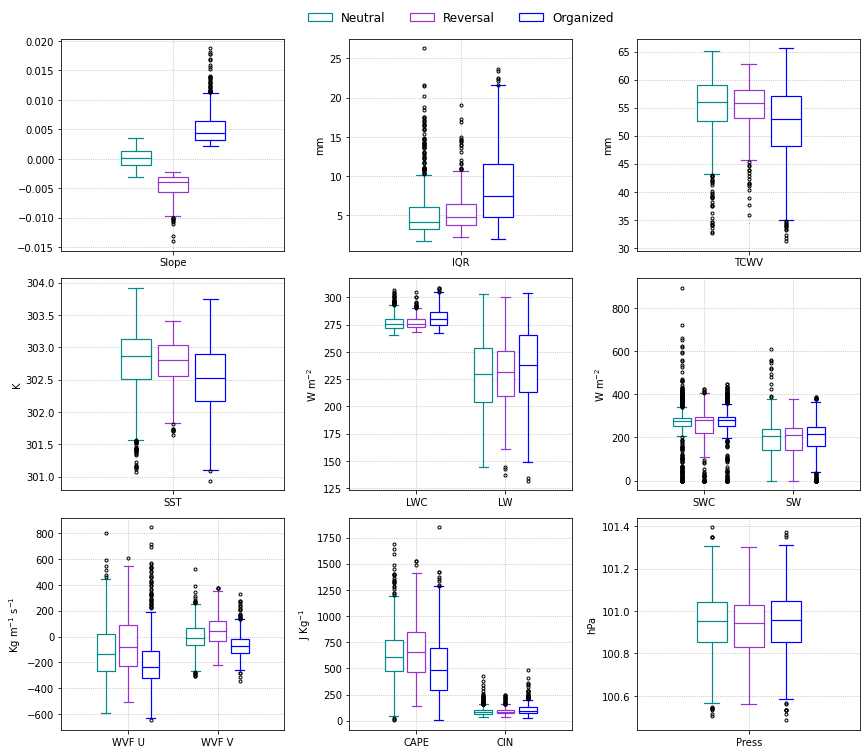

In [35]:
varis = [slopes.columns, met_data.columns[0:1], met_data.columns[2:3], met_data.columns[1:2], 
         met_data.columns[3:5], met_data.columns[5:7], met_data.columns[61:63], met_data.columns[63:65],
         met_data.columns[65:66]]

units = ['', 'mm', 'mm', 'K', 'W m$^{-2}$', 'W m$^{-2}$', 'Kg m$^{-1}$ s$^{-1}$', 'J Kg$^{-1}$', 'hPa']

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3,3, left=0.05, right=0.975, hspace=0.13, wspace=0.29, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    if i == 0:
        ###### Slopes
        pos = np.arange(daymean_sne[var].shape[1])-sep
        bp = ax.boxplot(daymean_sne[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(daymean_slo[var].shape[1])+0.0
        bp1 = ax.boxplot(daymean_slo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(daymean_shi[var].shape[1])+(sep)
        bp2 = ax.boxplot(daymean_shi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")
    else:
        pos = np.arange(daymean_ne[var].shape[1])-sep
        bp = ax.boxplot(daymean_ne[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(daymean_lo[var].shape[1])+0.0
        bp1 = ax.boxplot(daymean_lo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(daymean_hi[var].shape[1])+(sep)
        bp2 = ax.boxplot(daymean_hi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")
        
    if i == 1:
        ax.legend([bp["boxes"][0],bp1["boxes"][0],bp2["boxes"][0]],['Neutral','Reversal','Organized'], 
                   bbox_to_anchor = (0.5,1.18),loc = 'upper center', ncol = 3, 
                   frameon = False, fontsize = 12)

    ax.set_xticks(pos1, var)
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
plt.savefig(path+'daily_all_ne.jpg', bbox_inches='tight')

# OLR from NOAA

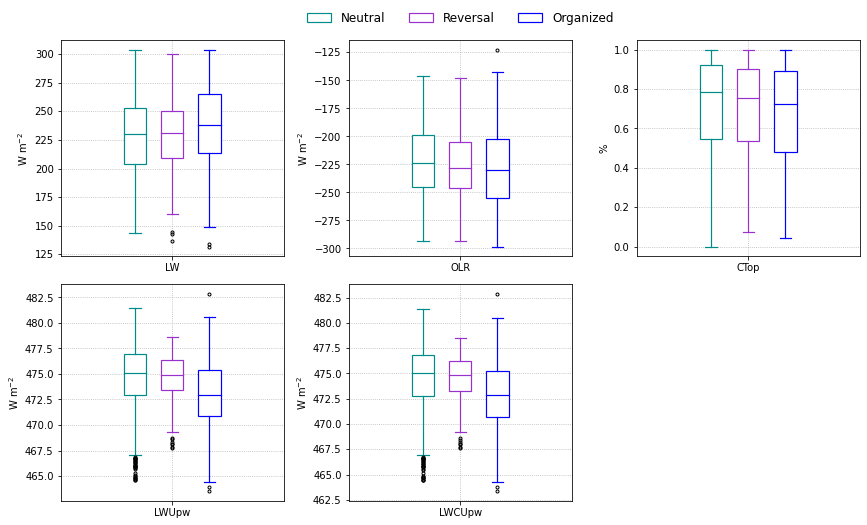

In [36]:
varis = [met_data.columns[4:5], olr.columns[0:], daymean_ctt.columns[0:], 
         met_data.columns[174:175], met_data.columns[175:176]]

units = ['W m$^{-2}$', 'W m$^{-2}$', '%', 'W m$^{-2}$', 'W m$^{-2}$']

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,3, left=0.05, right=0.975, hspace=0.13, wspace=0.29, top=0.9, bottom=0.1)
width = 0.15
for i,var in enumerate(varis):
    ax=subplot(gs[i])
    if i == 0 or i == 3 or i == 4:
        pos = np.arange(daymean_ne[var].shape[1])-sep
        bp = ax.boxplot(daymean_ne[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(daymean_lo[var].shape[1])+0.0
        bp1 = ax.boxplot(daymean_lo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(daymean_hi[var].shape[1])+(sep)
        bp2 = ax.boxplot(daymean_hi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")
    elif i == 1:
        pos = np.arange(daymean_one[var].shape[1])-sep
        bp = ax.boxplot(daymean_one[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(daymean_olo[var].shape[1])+0.0
        bp1 = ax.boxplot(daymean_olo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(daymean_ohi[var].shape[1])+(sep)
        bp2 = ax.boxplot(daymean_ohi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")
    elif i == 2:
        pos = np.arange(daymean_ctne[var].shape[1])-sep
        bp = ax.boxplot(daymean_ctne[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(daymean_ctlo[var].shape[1])+0.0
        bp1 = ax.boxplot(daymean_ctlo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(daymean_cthi[var].shape[1])+(sep)
        bp2 = ax.boxplot(daymean_cthi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")

    if i == 1:
        ax.legend([bp["boxes"][0],bp1["boxes"][0],bp2["boxes"][0]],['Neutral','Reversal','Organized'], 
                   bbox_to_anchor = (0.5,1.18),loc = 'upper center', ncol = 3, 
                   frameon = False, fontsize = 12)

    ax.set_xticks(pos1, var)
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
plt.savefig(path+'LW_Cfrac_box.jpg', bbox_inches='tight')

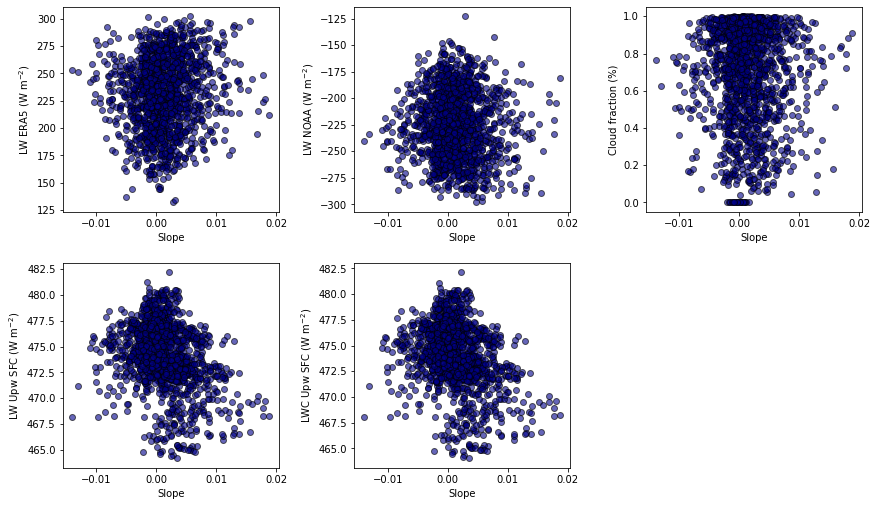

In [37]:
varis = [daymean_t[met_data.columns[4:5]], olr[olr.columns[0:]]*(-1), daymean_ctt[daymean_ctt.columns[0:]], 
         daymean_t[met_data.columns[174:175]], daymean_t[met_data.columns[175:176]]]

units = ['LW ERA5 (W m$^{-2}$)', 'LW NOAA (W m$^{-2}$)', 'Cloud fraction (%)', 
         'LW Upw SFC (W m$^{-2}$)', 'LWC Upw SFC (W m$^{-2}$)']

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,3, left=0.05, right=0.975, hspace=0.25, wspace=0.35, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    plt.scatter(daymean_st['Slope'], var, color = 'darkblue', alpha = 0.6, edgecolor = 'k')
    #plt.scatter(daymean_slo['Slope'], daymean_lo[var], color = 'darkorchid', s = 6, alpha = 0.6)
    #plt.scatter(daymean_shi['Slope'], daymean_hi[var], color = 'blue', s = 5, alpha = 0.6)
    plt.ylabel(units[i])
    plt.xlabel('Slope')
plt.savefig(path+'Rad_clouds_scatter.jpg', bbox_inches='tight')

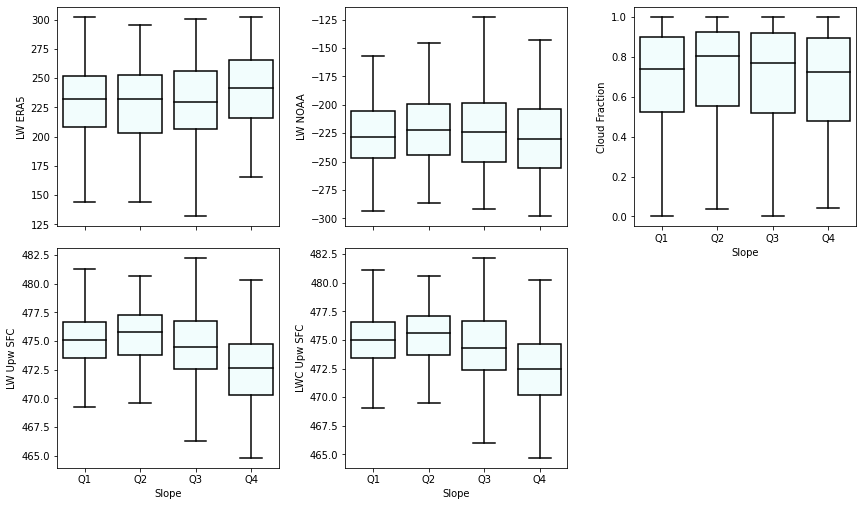

In [86]:
varis = ['LW', 'OLR', 'CTop', 'LWUpw', 'LWCUpw']
varname = ['LW ERA5','LW NOAA','Cloud Fraction','LW Upw SFC','LWC Upw SFC']

fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,3, left=0.05, right=0.975, hspace=0.1, wspace=0.3, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = scatter_box(var, varname[i], 4)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x='bins', y='Value', hue='Conditions', palette=['azure'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black'), showfliers= False
                     )
    plt.legend('', frameon = False)
    if i > 1:
        plt.xticks(np.arange(0,4), ['Q1','Q2','Q3','Q4'])
        plt.xlabel('Slope')
    else:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    plt.ylabel(varname[i])
plt.savefig(path+'Rad_clouds_scatter_box.jpg', bbox_inches='tight')

## TCWV MIMIC

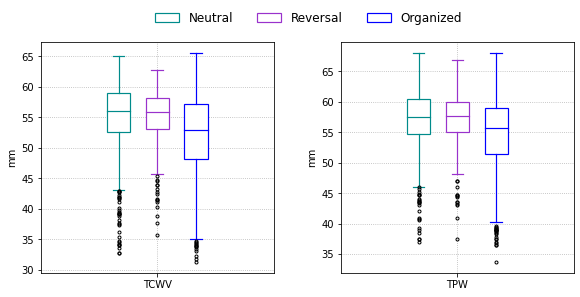

In [39]:
varis = [met_data.columns[2:3], mimic.columns[0:]]

units = ['mm', 'mm']

fig = plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(1,2, left=0.05, right=0.975, hspace=0.13, wspace=0.29, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    if i == 0:
        pos = np.arange(daymean_ne[var].shape[1])-sep
        bp = ax.boxplot(daymean_ne[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(daymean_lo[var].shape[1])+0.0
        bp1 = ax.boxplot(daymean_lo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(daymean_hi[var].shape[1])+(sep)
        bp2 = ax.boxplot(daymean_hi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")
    elif i == 1:
        pos = np.arange(daymean_pwne[var].shape[1])-sep
        bp = ax.boxplot(daymean_pwne[var], positions= pos, widths=width, 
                        patch_artist=True, sym = '.')
        draw_plot(pos,bp,-sep, "darkcyan", "white")

        pos1 = np.arange(daymean_pwlo[var].shape[1])+0.0
        bp1 = ax.boxplot(daymean_pwlo[var], positions= pos1, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos1,bp1,+0.0, "darkorchid", "white")

        pos2 = np.arange(daymean_pwhi[var].shape[1])+(sep)
        bp2 = ax.boxplot(daymean_pwhi[var], positions= pos2, widths=width, 
                         patch_artist=True, sym = '.')
        draw_plot(pos2,bp2,+sep, "blue", "white")

    if i == 0:
        ax.legend([bp["boxes"][0],bp1["boxes"][0],bp2["boxes"][0]],['Neutral','Reversal','Organized'], 
                   bbox_to_anchor = (1.15,1.18),loc = 'upper center', ncol = 3, 
                   frameon = False, fontsize = 12)

    ax.set_xticks(pos1, var)
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')

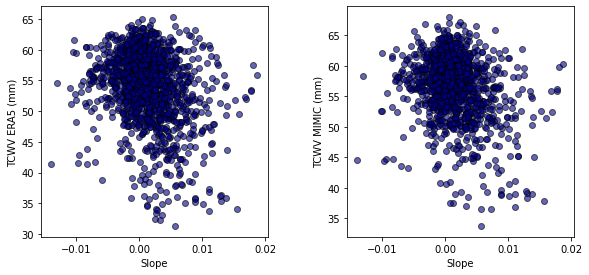

In [40]:
varis = [daymean_t[met_data.columns[2:3]], mimic[mimic.columns[0:]]]

units = ['TCWV ERA5 (mm)', 'TCWV MIMIC (mm)']

fig = plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(1,2, left=0.05, right=0.975, hspace=0.25, wspace=0.35, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    ax=subplot(gs[i])
    if i == 1:
        plt.scatter(daymean_st['Slope'].loc['2016-10-01':'2019-12-31'], var.loc['2016-10-01':'2019-12-31'], 
                    color = 'darkblue', alpha = 0.6, edgecolor = 'k')
    else:
        plt.scatter(daymean_st['Slope'], var, color = 'darkblue', alpha = 0.6, edgecolor = 'k')
    plt.ylabel(units[i])
    plt.xlabel('Slope')
plt.savefig(path+'Moist_scatter.jpg', bbox_inches='tight')

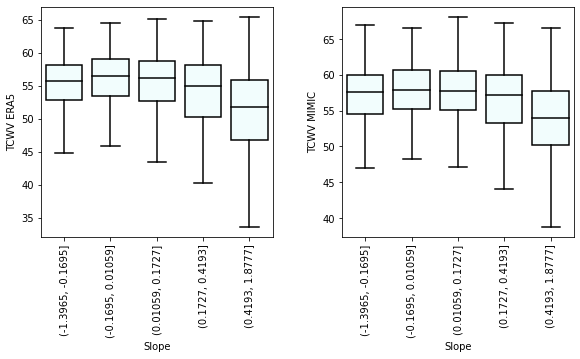

In [41]:
varis = ['TCWV', 'TPW']
varname = ['TCWV ERA5','TCWV MIMIC']

fig = plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(1,2, left=0.05, right=0.975, hspace=0.1, wspace=0.3, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = scatter_box(var, varname[i], 5)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x='bins', y='Value', hue='Conditions', palette=['azure'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black'), showfliers= False
                     )
    plt.legend('', frameon = False)
    plt.xticks(rotation=90)
    plt.ylabel(varname[i])
    plt.xlabel('Slope')
plt.savefig(path+'Moist_scatter_box.jpg', bbox_inches='tight')

# Figures for the papers!

## Organized and reversal states characteristics

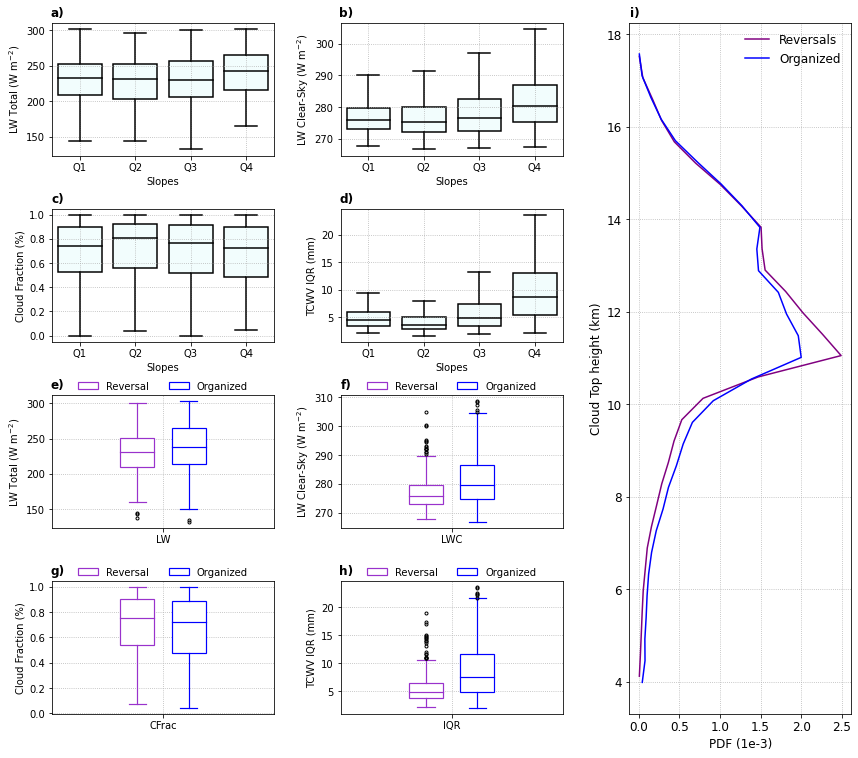

In [42]:
varis = ['LW', 'LWC', 'CTop', 'IQR']
varname = ['LW Total (W m$^{-2}$)','LW Clear-Sky (W m$^{-2}$)', 'Cloud Fraction (%)', 'TCWV IQR (mm)']
title = ['a)', 'b)', 'c)', 'd)']

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,3, left=0.05, right=0.975, hspace=0.4, wspace=0.3, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = scatter_box(var, varname[i], 4)
    if i < 2:
        ax=subplot(gs[i])
    else:
        ax=subplot(gs[i+1])
    bp = sns.boxplot(data = df, x='bins', y='Value', hue='Conditions', palette=['azure'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black'), showfliers= False
                     )
    plt.legend('', frameon = False)
    plt.xticks(np.arange(0,4), ['Q1','Q2','Q3','Q4'])
    plt.ylabel(varname[i])
    plt.xlabel('Slopes')
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    
varis = [daymean_lo[met_data.columns[4:5]], daymean_lo[met_data.columns[3:4]], 
         daymean_ctlo[daymean_ctt.columns[0:]], daymean_lo[met_data.columns[0:1]]]
var_hi = [daymean_hi[met_data.columns[4:5]], daymean_hi[met_data.columns[3:4]], 
          daymean_cthi[daymean_ctt.columns[0:]], daymean_hi[met_data.columns[0:1]]]

units = ['LW Total (W m$^{-2}$)','LW Clear-Sky (W m$^{-2}$)', 'Cloud Fraction (%)', 'TCWV IQR (mm)']
xtick = [['LW'],['LWC'],['CFrac'],['IQR']]
title = ['e)', 'f)', 'g)', 'h)']
    
sep_fig = 0.15
width = 0.2
for i,var in enumerate(varis):
    if i < 2:
        ax=subplot(gs[i+6])
    else:
        ax=subplot(gs[i+7])
    pos1 = np.arange(var.shape[1])-(sep_fig)
    bp1 = ax.boxplot(var, positions= pos1, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos1,bp1,-sep_fig, "darkorchid", "white")

    pos2 = np.arange(var_hi[i].shape[1])+(sep_fig)
    bp2 = ax.boxplot(var_hi[i], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.')
    draw_plot(pos2,bp2,+sep_fig, "blue", "white")
    pos = np.arange(var_hi[i].shape[1])+0
    ax.set_xticks(pos, xtick[i])
    ax.set_ylabel(units[i])
    plt.grid(linestyle = ':')
    plt.title(title[i], x=0.025, fontweight = 'bold')
    ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
               bbox_to_anchor = (0.5,1.17),loc = 'upper center', ncol = 2, 
               frameon = False, fontsize = 10)
    
ax=subplot(gs[0:4,2])   
plt.plot(pdf_lo_ct*1e3, bin_edges_lo_ct[1:]/100, color = 'purple', label = 'Reversals')
plt.plot(pdf_hi_ct*1e3, bin_edges_hi_ct[1:]/100, color = 'blue', label = 'Organized')
plt.ylabel('Cloud Top height (km)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.grid(linestyle = ':')
plt.title('i)', x = 0.025, fontweight = 'bold')
plt.xlabel('PDF (1e-3)', fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(frameon = False, fontsize = 12)
plt.savefig(path+'Fig_OLR_moist.pdf', bbox_inches='tight', dpi=300)

## Wind conditions and maps for organize and reversal states

In [43]:
from shapely.geometry.polygon import LinearRing
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
import pdb
import datetime as dt
import os

In [44]:
ds_EW = xr.open_dataset('../NN_real/Zonal_850_apr_2017.nc')
ds_SN = xr.open_dataset('../NN_real/Meridional_850_apr_2017.nc')
EW = ds_EW['u'][:,:,:]
SN = ds_SN['v'][:,:,:]

ds_tcwv = xr.open_dataset('../NN_real/TCWV_apr_2017.nc')
tcwv = ds_tcwv['tcwv']

### Study area!
a_lat = [2,2,9,9]
a_lon = [135,145,145,135]
ring = LinearRing(list(zip(a_lon, a_lat)))

/Users/Casi94/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:336: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/Casi94/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/Casi94/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:336: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/Casi94/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings

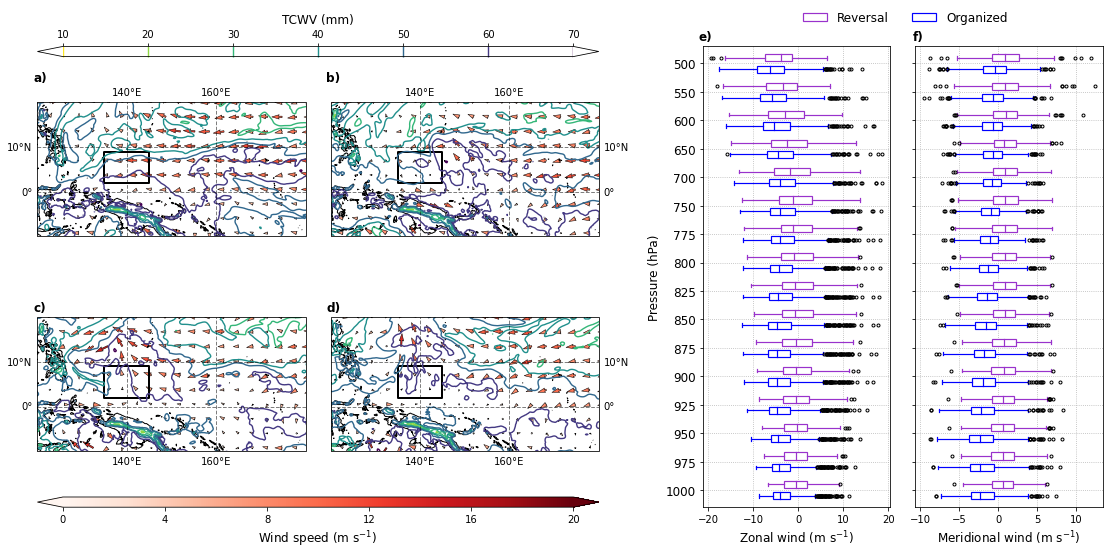

In [45]:
varis = [zonally, meridionally]
names = ['Zonal wind', 'Meridional wind']
title_box = ['e)','f)']

dates = ['2017-04-18 04:00:00', '2017-04-22 00:00:00', '2017-04-25 00:00:00', '2017-04-26 16:00:00']
title_wi = ['a)','b)','c)','d)']

fig = plt.figure(figsize=(16,8)) #16,8
gs = gridspec.GridSpec(4,5, left=0.05, right=0.975, hspace=0.1, wspace=0.13, top=0.9, bottom=0.1, 
                       height_ratios=[0.05,1,1,0.05], width_ratios=[1,1,0.2,0.7,0.7])
sep = 0.2
width = 0.25
jum = 13

for i,time in enumerate(dates):
    magni = np.sqrt(EW.sel(time=time)[:,:]*EW.sel(time=time)[:,:]+SN.sel(time=time)[:,:]*SN.sel(time=time)[:,:])
    if i < 2:
        ax = plt.subplot(gs[i+5],projection= ccrs.PlateCarree(central_longitude=180))
    else: 
        ax = plt.subplot(gs[i+8],projection= ccrs.PlateCarree(central_longitude=180))
    im = plt.quiver(ds_EW['longitude'][::jum],ds_EW['latitude'][::jum], 
                    np.array(EW.sel(time=time)[0,::jum,::jum]), 
                    np.array(SN.sel(time=time)[0,::jum,::jum]), 
                    magni[0,::jum,::jum], cmap='Reds', transform = ccrs.PlateCarree(), 
                    clim=[0,20], edgecolor='k', linewidth = 0.5, width=0.0055)
    im1 = plt.contour(ds_tcwv['longitude'],ds_tcwv['latitude'], tcwv.sel(time=time)[:,:], 
                      cmap='viridis_r', transform = ccrs.PlateCarree(), extend = 'both', 
                      levels=np.arange(10,71,10), linewidths=1.4)
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)
    ax.add_feature(cfeature.COASTLINE)
    plt.title(title_wi[i], fontsize = 12, x = 0.01, fontweight = 'bold')
    ax.set_extent([120, 180, -10, 20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, 
                      linewidth = 1, color='k', alpha = 0.5, linestyle = '--')
    if i == 0: 
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_bottom = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_right = False
    elif i == 1:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_bottom = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_left = False
    elif i == 2:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_top = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_right = False
    elif i == 3:
        gl.xlocator = mticker.FixedLocator([120, 140, 160, 180]); gl.xlabels_top = False 
        gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20]); gl.ylabels_left = False
    #plt.xlim(120,180)
    plt.ylim(-10,20)
    
ax = plt.subplot(gs[0,0:2])
cbar1 = plt.colorbar(im1,cax=ax,orientation='horizontal',shrink = 0.4, ticks=np.arange(10,71,10))
cbar1.ax.xaxis.set_ticks_position("top")
cbar1.ax.set_title('TCWV (mm)', fontsize = 12)

ax = plt.subplot(gs[3,0:2])
cbar = plt.colorbar(im,cax=ax,orientation='horizontal',shrink = 0.4,extend='both', ticks=np.arange(0,21,4))
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.set_label('Wind speed (m s$^{-1}$)', fontsize = 12)

for i,var in enumerate(varis):
    if i == 0:
        ax=subplot(gs[0:4,3])
    else:
        ax=subplot(gs[0:4,4])
    pos = np.arange(daymean_lo[var].shape[1])-0.0

    pos1 = np.arange(daymean_lo[var].shape[1])-sep
    bp1 = ax.boxplot(daymean_lo[var], positions= pos1, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos1,bp1,-sep, "darkorchid", "white")

    pos2 = np.arange(daymean_hi[var].shape[1])+(sep)
    bp2 = ax.boxplot(daymean_hi[var], positions= pos2, widths=width, 
                     patch_artist=True, sym = '.', vert=False)
    draw_plot(pos2,bp2,+sep, "blue", "white")
    
    plt.ylim(15.6,-0.6)
    ax.set_yticks(pos, pressure)
    plt.yticks(fontsize = 12)
    ax.set_xlabel(names[i]+' (m s$^{-1}$)', fontsize = 12)
    plt.grid(linestyle = ':')
    plt.title(title_box[i], fontweight = 'bold', x=0.015, fontsize = 12)
    if i == 1:
        ax.yaxis.set_major_formatter(NullFormatter())
    else:
        ax.set_ylabel('Pressure (hPa)', fontsize = 12)
        ax.legend([bp1["boxes"][0],bp2["boxes"][0]],['Reversal','Organized'], 
                   bbox_to_anchor = (1.08,1.1),loc = 'upper center', ncol = 2, 
                   frameon = False, fontsize = 12)
plt.savefig(path+'Fig_wind_reversals.pdf', bbox_inches='tight', dpi=300)

In [46]:
print('Reversals: '+str(int(msize_lo_slo.sum())))
print('Organised: '+str(int(msize_hi_slo.sum())))

Reversals: 217
Organised: 495


In [47]:
sor_mon = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
msize_hi_slo = msize_hi_slo.reindex(sor_mon, axis=0)

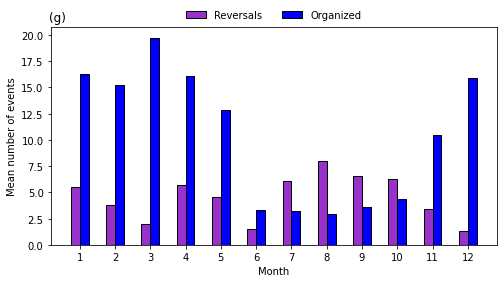

In [48]:
plt.figure(figsize=(8,4))
plt.bar(np.arange(1,13)-width/2, msize_lo_slo/4, edgecolor = 'k', 
        color = 'darkorchid', label = 'Reversals', width = width)
plt.bar(np.arange(1,13)+width/2, msize_hi_slo/4, edgecolor = 'k', 
        color = 'blue', label = 'Organized', width = width)
plt.legend(bbox_to_anchor=(0.5,1.12), loc = 'upper center', ncol = 2, frameon = False)
plt.xticks(np.arange(1,13))
plt.ylabel('Mean number of events')
plt.xlabel('Month')
plt.title('(g)', fontsize = 12, x = 0.015)
plt.savefig(path+'annual_cycle.jpg', bbox_inches='tight')

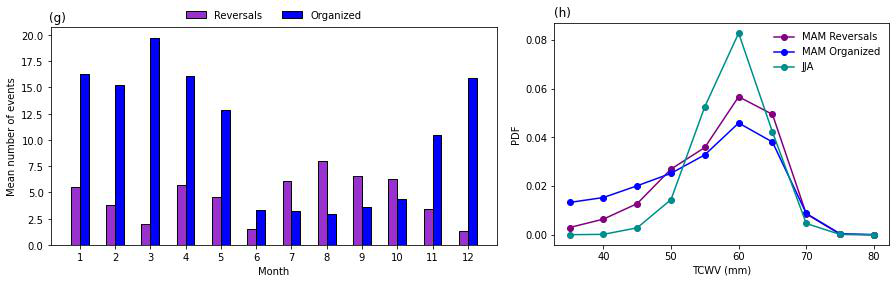

In [82]:
import numpy as np
import sys
import PIL
from PIL import Image

#Merge horizontally
images = [Image.open(x) for x in [path+'annual_cycle.jpg', path+'pdf_org_rev.jpg']]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save(path+'pdf_annual.jpg')
new_im.save(path+'pdf_annual.pdf')
new_im

<ipython-input-83-2c05a53db5eb>:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
<ipython-input-83-2c05a53db5eb>:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.vstack( (np.asarray( i.resize(min_shape[j]) ) for j,i in enumerate(imgs) ) )


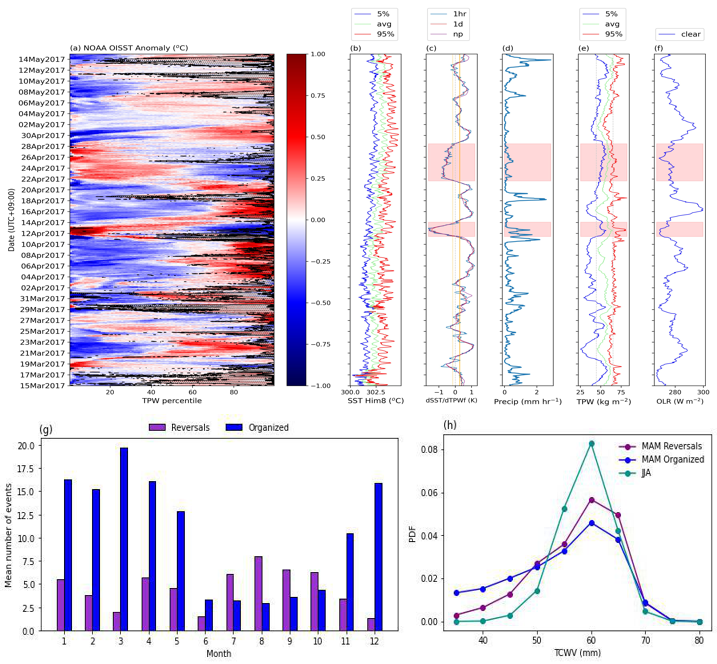

In [83]:
list_im = ['hovsst_gpm_wpac_2-9N_anim20170315-20170514.jpeg', path+'pdf_annual.jpg']
imgs    = [ PIL.Image.open(i) for i in list_im ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )   

min_shape = [(717,414),(717,250)]
# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( i.resize(min_shape[j]) ) for j,i in enumerate(imgs) ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save(path+'Fig_hov_annual_pdf.pdf')
imgs_comb

<ipython-input-51-f5958d43417c>:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
<ipython-input-51-f5958d43417c>:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  imgs_comb = np.vstack( (np.asarray( i.resize(min_shape[j]) ) for j,i in enumerate(imgs) ) )


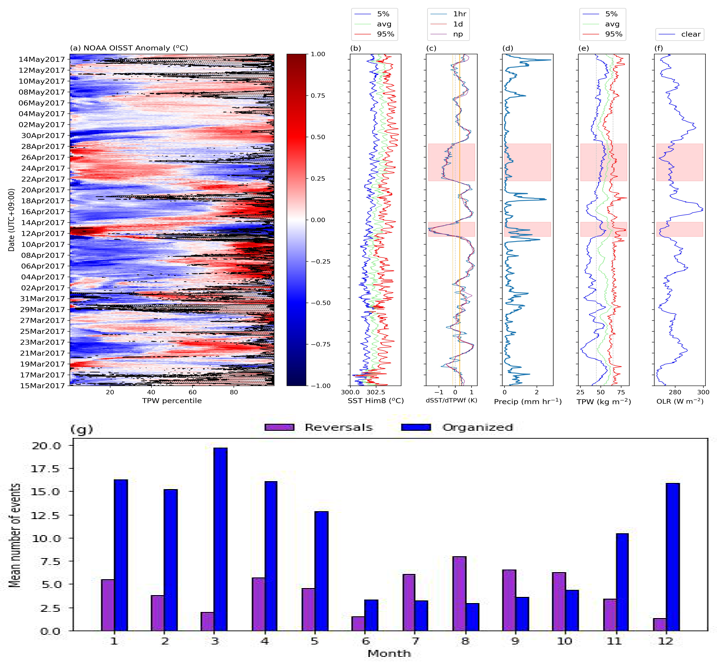

In [51]:
list_im = ['hovsst_gpm_wpac_2-9N_anim20170315-20170514.jpeg', path+'annual_cycle.jpg']
imgs    = [ PIL.Image.open(i) for i in list_im ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )   

min_shape = [(717,414),(717,250)]
# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( i.resize(min_shape[j]) ) for j,i in enumerate(imgs) ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save(path+'Fig_hov_annual.pdf')
imgs_comb

## For the multiyear statistics!

### Month!!

In [52]:
pressure = [ 100,  125,  150,  175,  200,  225,  250,  300,  350,  400, 450,
             500,  550,  600,  650,  700,  750,  775,  800,  825,  850,  875,  
             900,  925,  950,  975, 1000]
zonally = met_data.columns[7:34]
meridionally = met_data.columns[34:61]

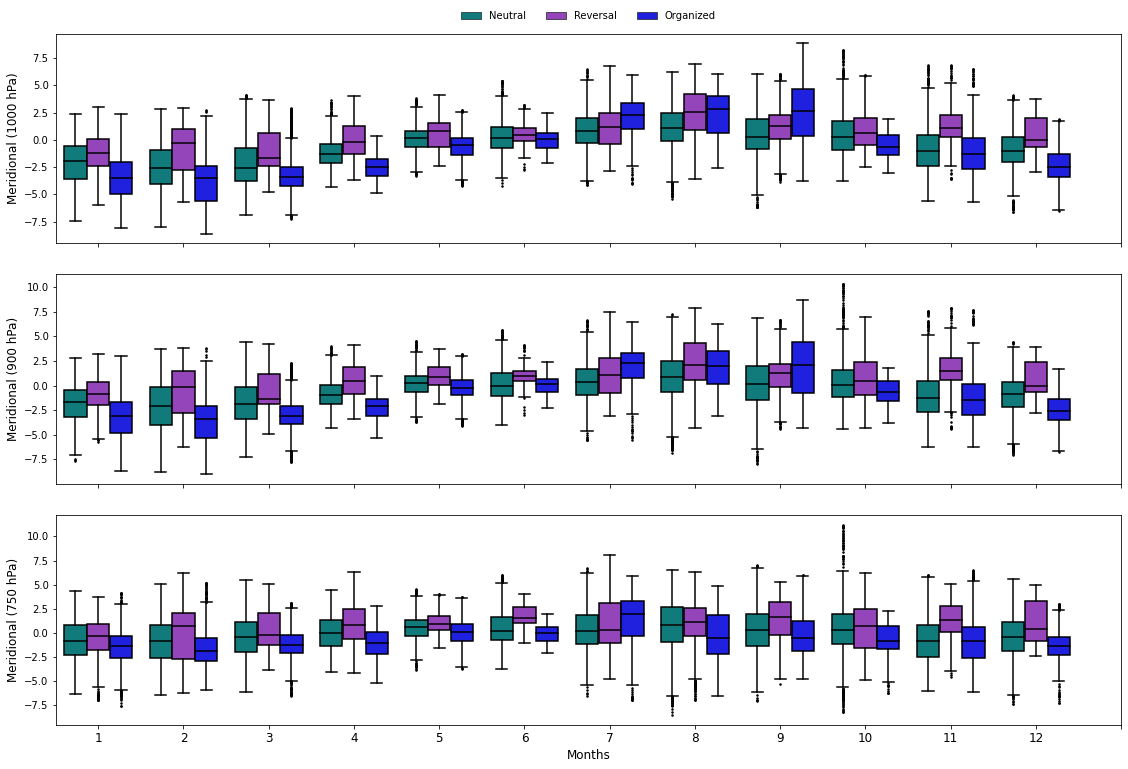

In [53]:
varis = ['V26','V22','V16']
titles = ['(1000 hPa)','(900 hPa)','(750 hPa)']

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.month, y='Value', hue='Conditions', 
                     palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,13), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Months', fontsize = 12)
    plt.ylabel('Meridional '+titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)

plt.savefig(path+'box_per_month_meridional_ne.jpg', bbox_inches='tight')
plt.show()

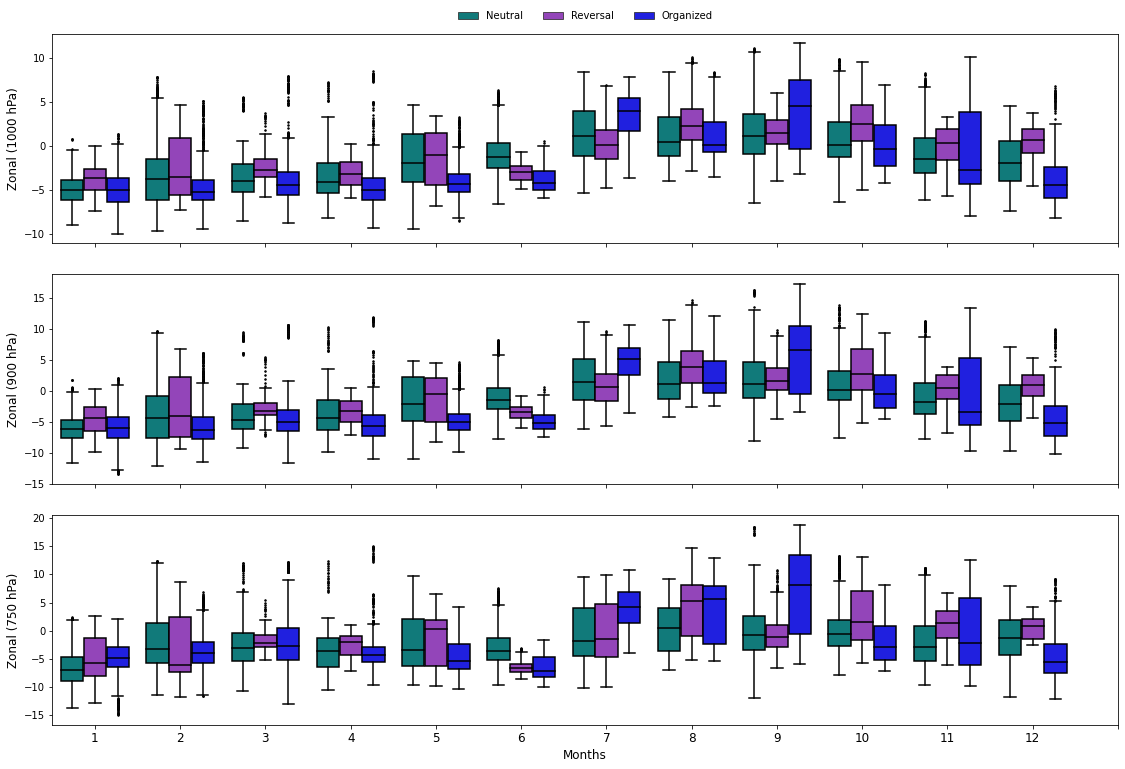

In [54]:
varis = ['U26','U22','U16']
titles = ['(1000 hPa)','(900 hPa)','(750 hPa)']

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.month, y='Value', hue='Conditions', 
                     palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,13), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Months', fontsize = 12)
    plt.ylabel('Zonal '+titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)
        
plt.savefig(path+'box_per_month_zonal_ne.jpg', bbox_inches='tight')
plt.show()

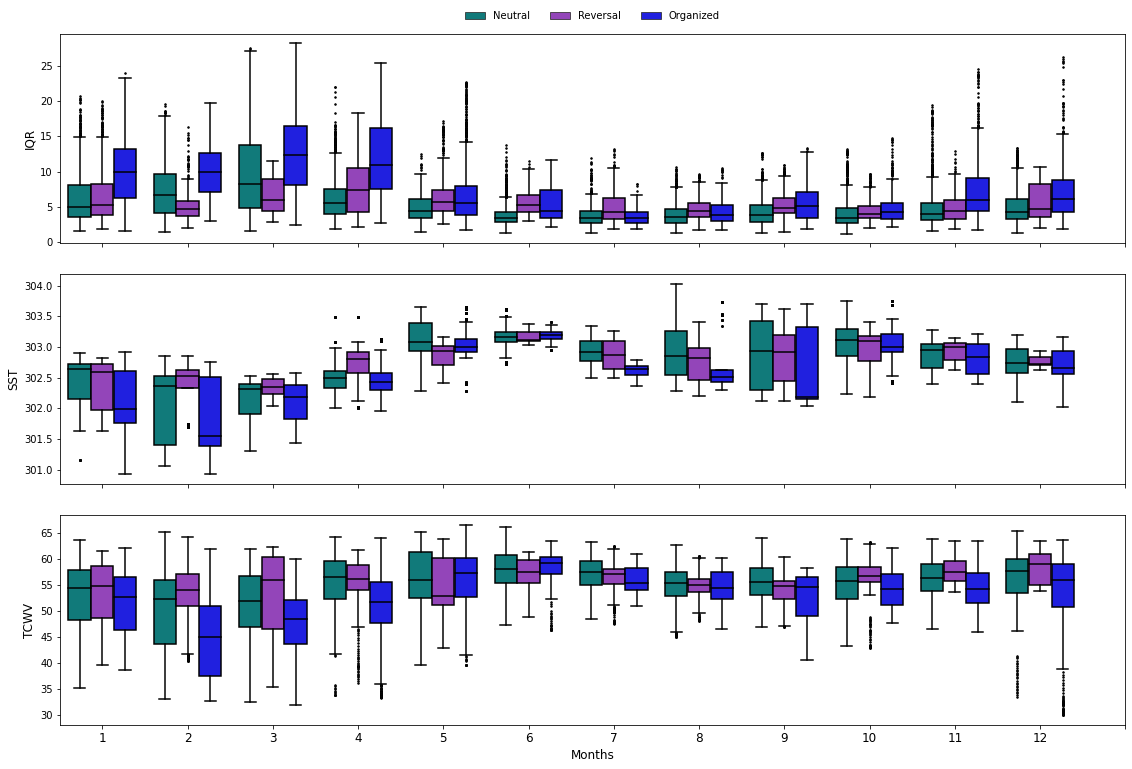

In [55]:
varis = ['IQR','SST','TCWV']
titles = ['IQR','SST','TCWV']

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.month, y='Value', hue='Conditions', palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,13), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Months', fontsize = 12)
    plt.ylabel(titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)
        
plt.savefig(path+'box_per_month_all_IQR_SST_ne.jpg', bbox_inches='tight')

plt.show()

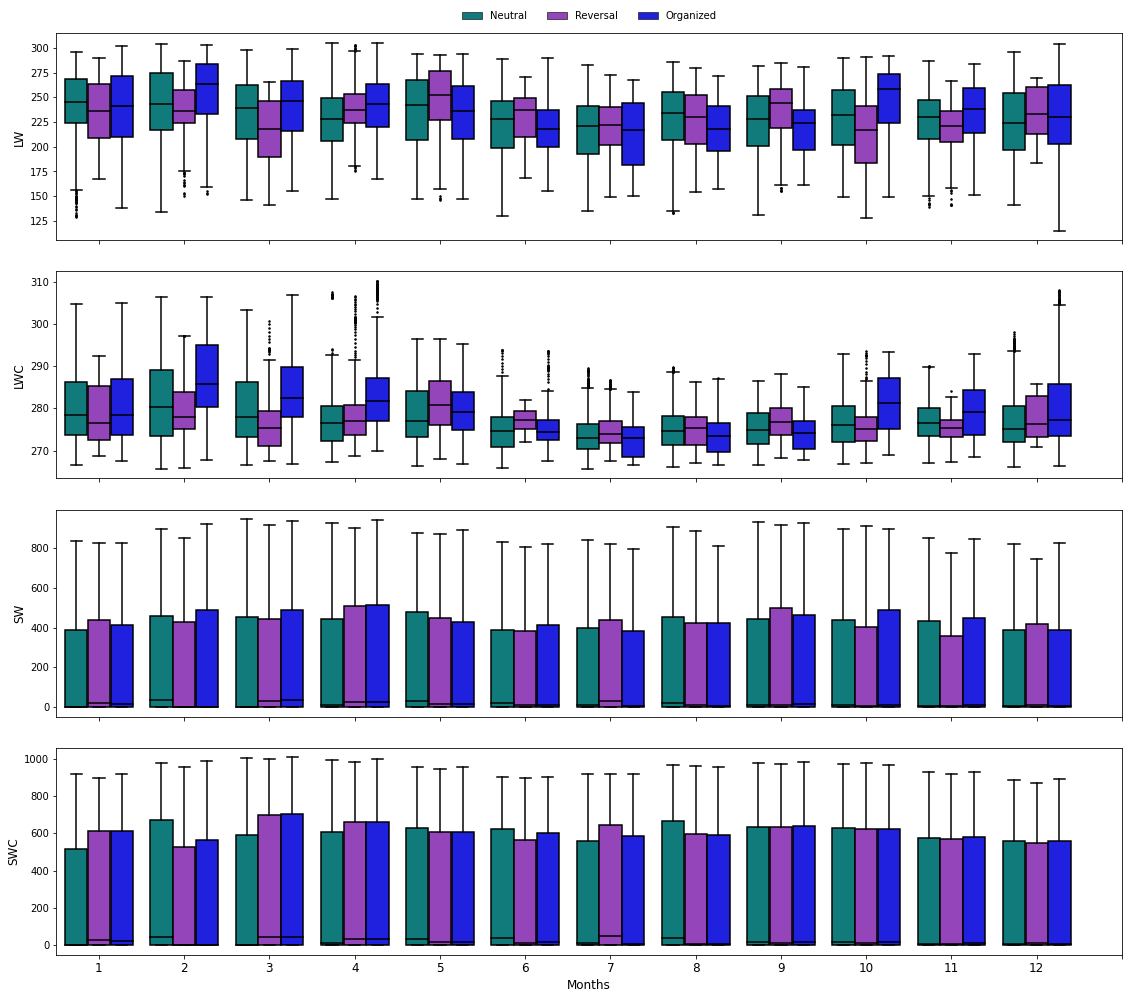

In [56]:
varis = ['LW','LWC','SW','SWC']
titles = ['LW','LWC','SW','SWC']

fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(4,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.month, y='Value', hue='Conditions', 
                     palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,13), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Months', fontsize = 12)
    plt.ylabel(titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)

plt.savefig(path+'box_per_month_all_Rad_ne.jpg', bbox_inches='tight')
        
plt.show()

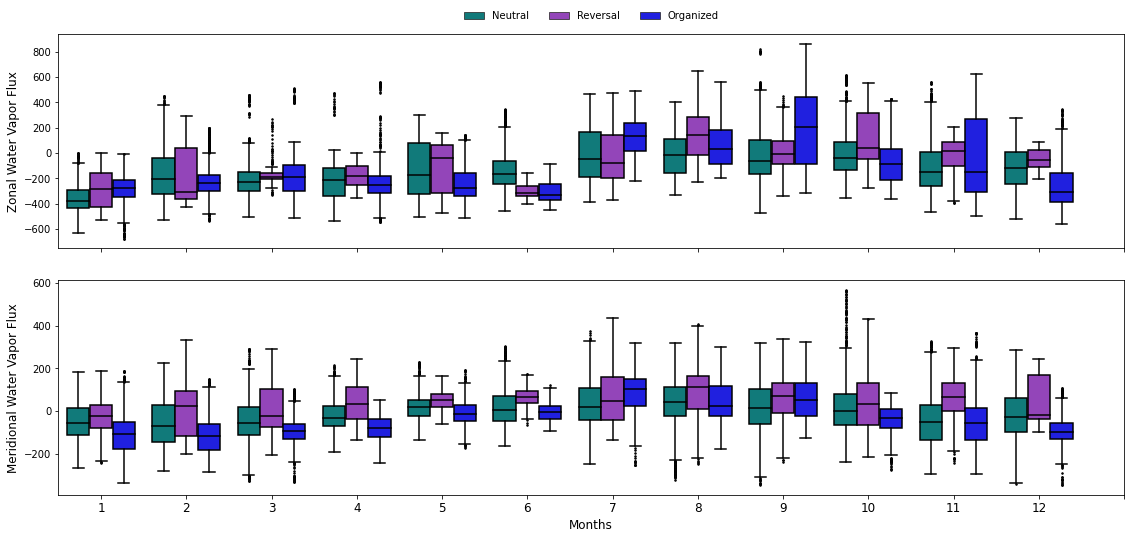

In [57]:
varis = ['WVF U','WVF V']
titles = ['Zonal Water Vapor Flux','Meridional Water Vapor Flux']

fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.month, y='Value', hue='Conditions', palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,13), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Months', fontsize = 12)
    plt.ylabel(titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)
        
plt.savefig(path+'box_per_month_all_WVF_ne.jpg', bbox_inches='tight')

plt.show()

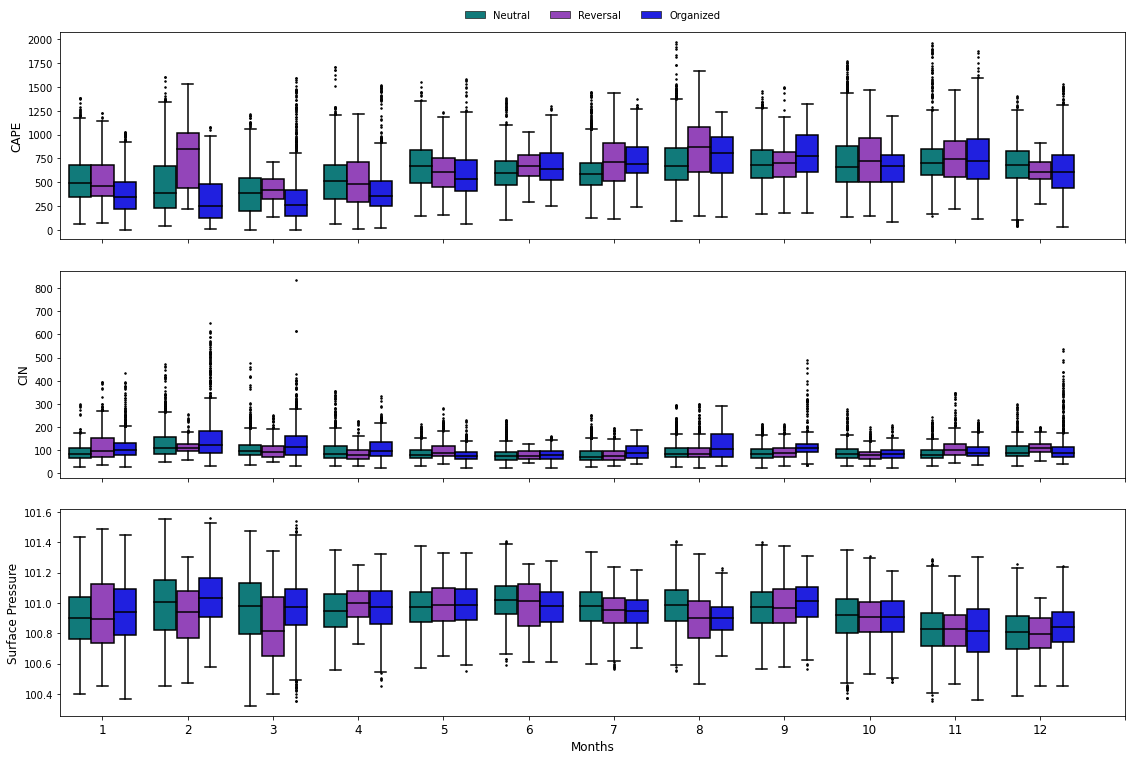

In [58]:
varis = ['CAPE','CIN','Press']
titles = ['CAPE','CIN','Surface Pressure']

fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(4,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.month, y='Value', hue='Conditions', palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,13), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Months', fontsize = 12)
    plt.ylabel(titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)
        
plt.savefig(path+'box_per_month_all_CAPE_Press_ne.jpg', bbox_inches='tight')

plt.show()

### Shear

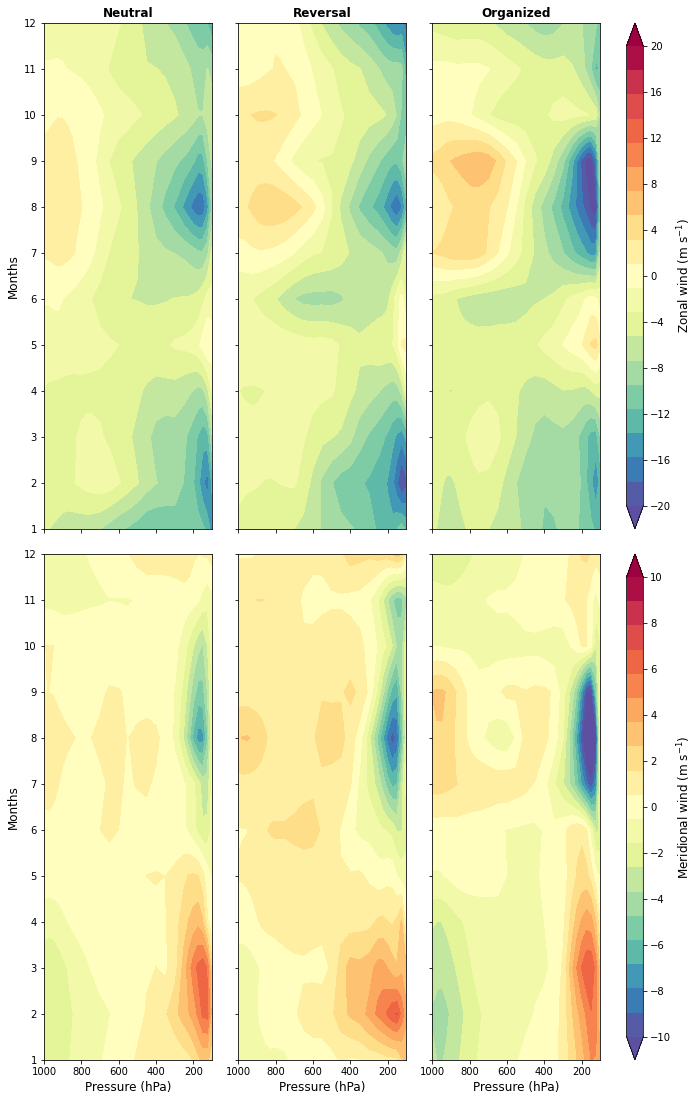

In [59]:
varis = [np.array(month_ne_met[zonally]), np.array(month_lo_met[zonally]), 
         np.array(month_hi_met[zonally]), np.array(month_ne_met[meridionally]), 
         np.array(month_lo_met[meridionally]), np.array(month_hi_met[meridionally])]
titles = ['Neutral', 'Reversal', 'Organized']
levels = [np.linspace(-20,20,20),np.linspace(-20,20,20),np.linspace(-20,20,20),
         np.linspace(-10,10,20),np.linspace(-10,10,20),np.linspace(-10,10,20)]

fig = plt.figure(figsize=(9,18))
gs = gridspec.GridSpec(2,4, left=0.05, right=0.975, hspace=0.05, wspace=0.2, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,1,0.1])

for i,var in enumerate(varis):
    if i < 3:
        ax=subplot(gs[i])
        im = plt.contourf(pressure, np.arange(1,13), var, cmap = 'Spectral_r', 
                      levels = levels[i], extend = 'both')
    else:
        ax=subplot(gs[i+1])
        im1 = plt.contourf(pressure, np.arange(1,13), var, cmap = 'Spectral_r', 
                      levels = levels[i], extend = 'both')
    if i < 3:
        plt.title(titles[i], fontweight = 'bold')
        ax.xaxis.set_major_formatter(NullFormatter())
    else:
        plt.xlabel('Pressure (hPa)', fontsize  = 12)
    plt.yticks(np.arange(1,13))
    plt.xlim(1000,100)
    if i == 0 or i == 3:
        plt.ylabel('Months', fontsize  = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
    
cax = plt.subplot(gs[3])
bar = plt.colorbar(im, orientation='vertical', cax=cax, ticks=np.arange(-20,21,4))
bar.set_label('Zonal wind (m s$^{-1}$)', fontsize  = 12)

cax = plt.subplot(gs[7])
bar1 = plt.colorbar(im1, orientation='vertical', cax=cax, ticks=np.arange(-10,11,2))
bar1.set_label('Meridional wind (m s$^{-1}$)', fontsize  = 12)

plt.savefig(path+'hov_per_month_shear_ne.jpg', bbox_inches='tight')


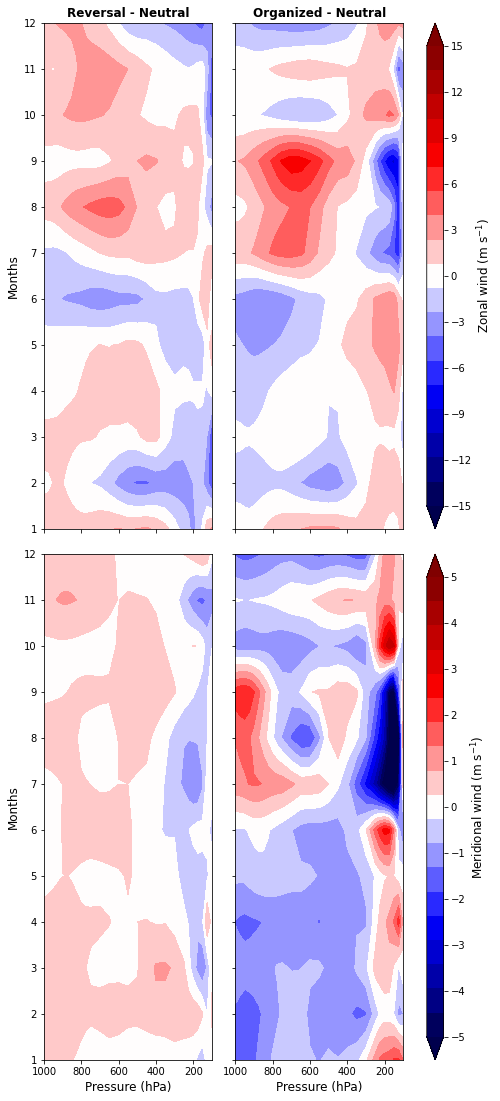

In [60]:
varis = [np.array(month_lo_met[zonally])-np.array(month_ne_met[zonally]), 
         np.array(month_hi_met[zonally])-np.array(month_ne_met[zonally]),
         np.array(month_lo_met[meridionally])-np.array(month_ne_met[meridionally]), 
         np.array(month_hi_met[meridionally])-np.array(month_ne_met[meridionally])]
titles = ['Reversal - Neutral', 'Organized - Neutral']
levels = [np.linspace(-15,15,20),np.linspace(-15,15,20),np.linspace(-15,15,20),
         np.linspace(-5,5,20),np.linspace(-5,5,20),np.linspace(-5,5,20)]

fig = plt.figure(figsize=(6,18))
gs = gridspec.GridSpec(2,3, left=0.05, right=0.975, hspace=0.05, wspace=0.2, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,0.1])

for i,var in enumerate(varis):
    if i < 2:
        ax=subplot(gs[i])
        im = plt.contourf(pressure, np.arange(1,13), var, cmap = 'seismic', 
                          levels = levels[i], extend = 'both')
    else:
        ax=subplot(gs[i+1])
        im1 = plt.contourf(pressure, np.arange(1,13), var, cmap = 'seismic', 
                          levels = levels[i], extend = 'both')
    if i < 2:
        plt.title(titles[i], fontweight = 'bold')
        ax.xaxis.set_major_formatter(NullFormatter())
    else:
        plt.xlabel('Pressure (hPa)', fontsize  = 12)
    plt.yticks(np.arange(1,13))
    plt.xlim(1000,100)
    if i == 0 or i == 2:
        plt.ylabel('Months', fontsize  = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
    
cax = plt.subplot(gs[2])
bar = plt.colorbar(im, orientation='vertical', cax=cax, ticks=np.arange(-15,16,3))
bar.set_label('Zonal wind (m s$^{-1}$)', fontsize  = 12)

cax = plt.subplot(gs[5])
bar1 = plt.colorbar(im1, orientation='vertical', cax=cax, ticks=np.arange(-5,6,1))
bar1.set_label('Meridional wind (m s$^{-1}$)', fontsize  = 12)

plt.savefig(path+'hov_per_month_shear_anom_ne.jpg', bbox_inches='tight')


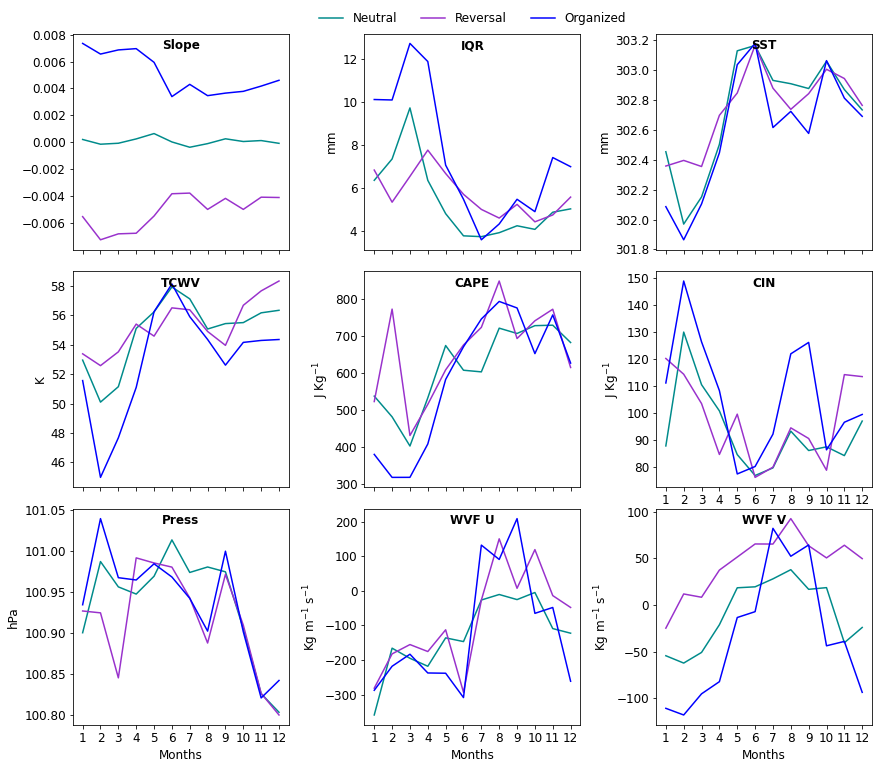

In [61]:
all_vars = ['Slope', 'IQR', 'SST', 'TCWV', 'CAPE', 'CIN', 'Press', 'WVF U', 'WVF V']
units = ['', 'mm', 'mm', 'K','J Kg$^{-1}$','J Kg$^{-1}$','hPa',
         'Kg m$^{-1}$ s$^{-1}$', 'Kg m$^{-1}$ s$^{-1}$']

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3,3, left=0.05, right=0.975, hspace=0.1, wspace=0.35, top=0.9, bottom=0.1)

x = np.arange(1,13)

for i,var in enumerate(all_vars):
    ax=subplot(gs[i])
    if i == 0:
        plt.plot(x,month_ne_slo[var], color = 'darkcyan', label = 'Neutral')
        plt.plot(x,month_lo_slo[var], color = 'darkorchid', label = 'Reversal')
        plt.plot(x,month_hi_slo[var], color = 'blue', label = 'Organized')
    else:
        plt.plot(x,month_ne_met[var], color = 'darkcyan', label = 'Neutral')
        plt.plot(x,month_lo_met[var], color = 'darkorchid', label = 'Reversal')
        plt.plot(x,month_hi_met[var], color = 'blue', label = 'Organized')
    plt.title(all_vars[i], y = 0.9, fontweight = 'bold')
    plt.yticks(fontsize = 12)
    plt.xticks(np.arange(1,13),fontsize = 12)
    plt.ylabel(units[i], fontsize = 12)
    if i == 1:
        plt.legend(bbox_to_anchor=(0.5,1.15), loc = 'upper center', ncol = 3, 
                   frameon = False, fontsize = 12)
    if i < 5:
        ax.xaxis.set_major_formatter(NullFormatter())
    else:
        plt.xlabel('Months', fontsize = 12)

plt.savefig(path+'monthly_mean_met_data_ne.jpg', bbox_inches='tight')

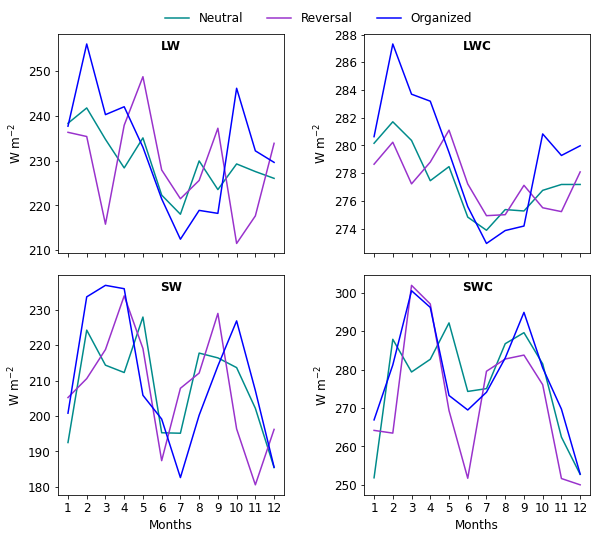

In [62]:
all_vars = ['LW', 'LWC', 'SW', 'SWC']
units = ['W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$']

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2,2, left=0.05, right=0.975, hspace=0.1, wspace=0.35, top=0.9, bottom=0.1)

x = np.arange(1,13)

for i,var in enumerate(all_vars):
    ax=subplot(gs[i])
    plt.plot(x,month_ne_met[var], color = 'darkcyan', label = 'Neutral')
    plt.plot(x,month_lo_met[var], color = 'darkorchid', label = 'Reversal')
    plt.plot(x,month_hi_met[var], color = 'blue', label = 'Organized')
    plt.title(all_vars[i], y = 0.9, fontweight = 'bold')
    plt.yticks(fontsize = 12)
    plt.xticks(np.arange(1,13),fontsize = 12)
    plt.ylabel(units[i], fontsize = 12)
    if i == 0:
        plt.legend(bbox_to_anchor=(1.15,1.15), loc = 'upper center', ncol = 3, 
                   frameon = False, fontsize = 12)
    if i < 2:
        ax.xaxis.set_major_formatter(NullFormatter())
    else:
        plt.xlabel('Months', fontsize = 12)

plt.savefig(path+'monthly_mean_rad_data_ne.jpg', bbox_inches='tight')

### Hour

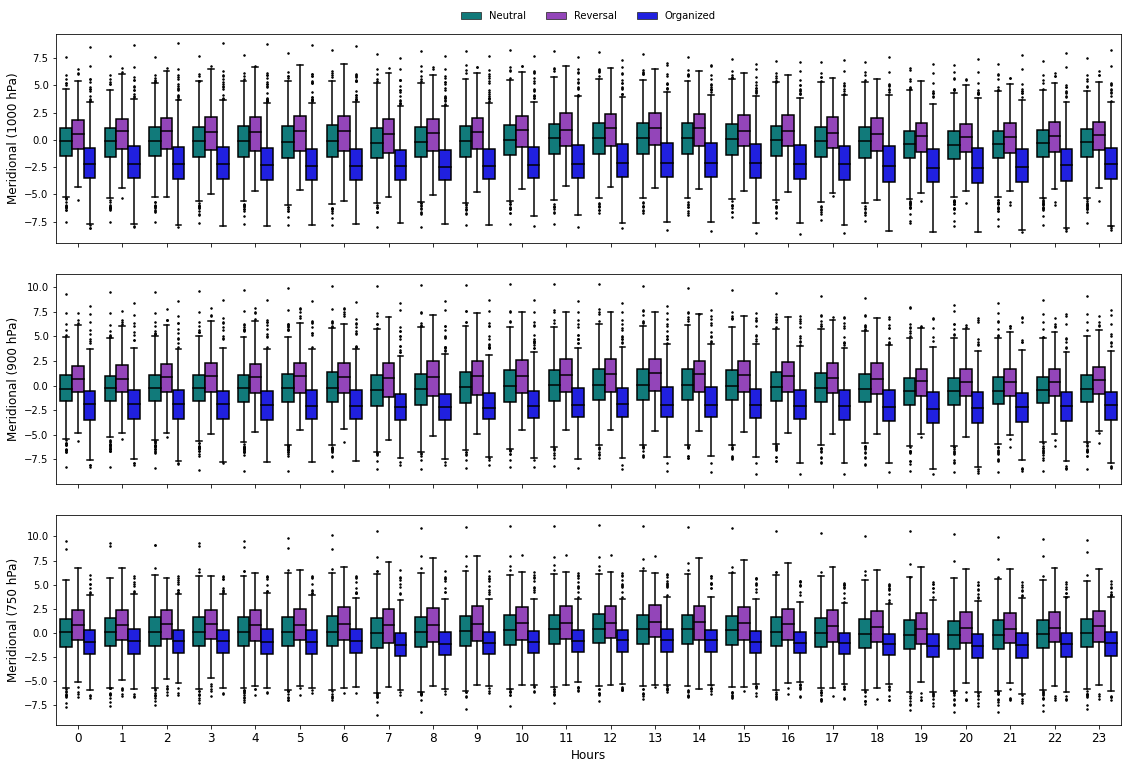

In [63]:
varis = ['V26','V22','V16']
titles = ['(1000 hPa)','(900 hPa)','(750 hPa)']

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.hour, y='Value', hue='Conditions', 
                     palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,24), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Hours', fontsize = 12)
    plt.ylabel('Meridional '+titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)

plt.savefig(path+'box_per_hour_meridional_ne.jpg', bbox_inches='tight')

plt.show()

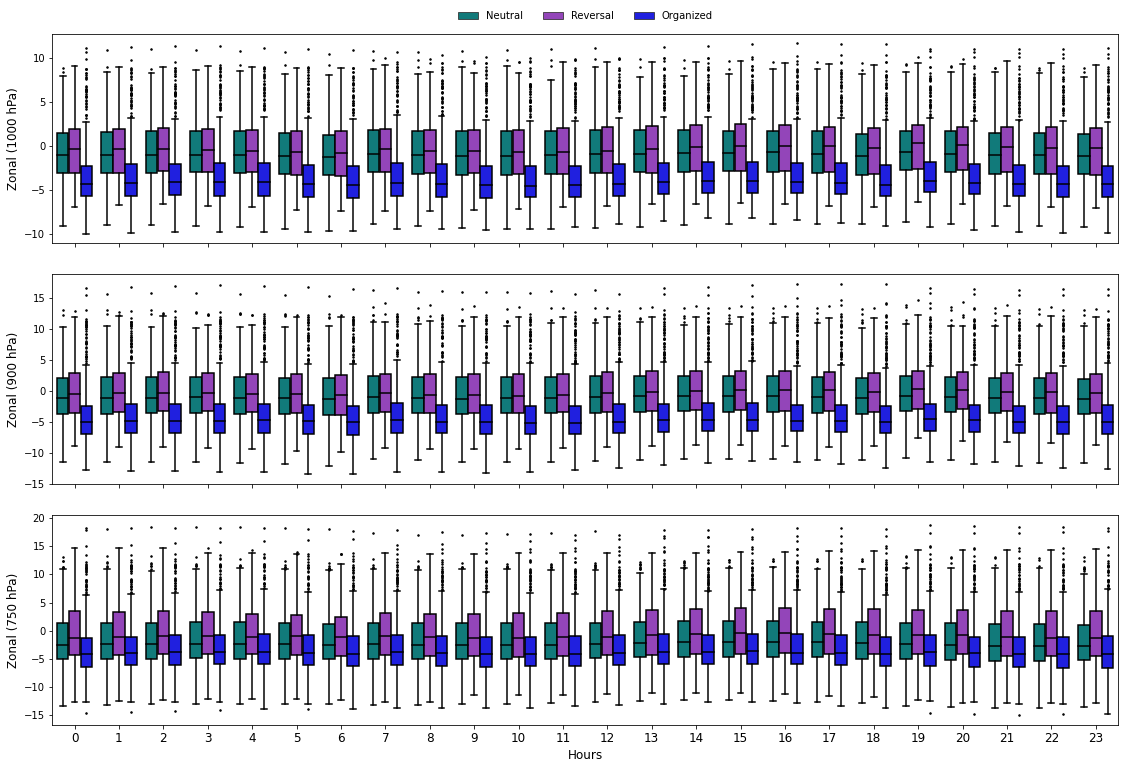

In [64]:
varis = ['U26','U22','U16']
titles = ['(1000 hPa)','(900 hPa)','(750 hPa)']

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.hour, y='Value', hue='Conditions', 
                     palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,24), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Hours', fontsize = 12)
    plt.ylabel('Zonal '+titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)

plt.savefig(path+'box_per_hour_zonal_ne.jpg', bbox_inches='tight')
        
plt.show()

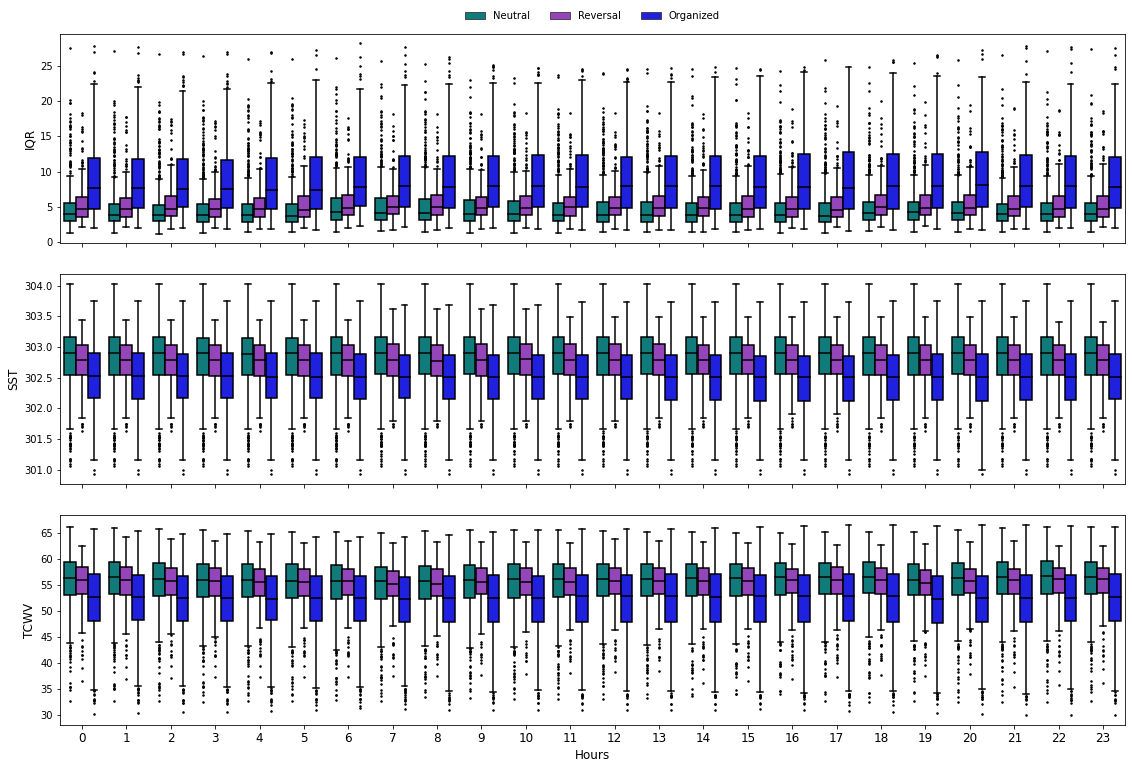

In [65]:
varis = ['IQR','SST','TCWV']
titles = ['IQR','SST','TCWV']

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.hour, y='Value', hue='Conditions', 
                     palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,24), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Hours', fontsize = 12)
    plt.ylabel(titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)
        
plt.savefig(path+'box_per_hour_IQR_SST_ne.jpg', bbox_inches='tight')

plt.show()

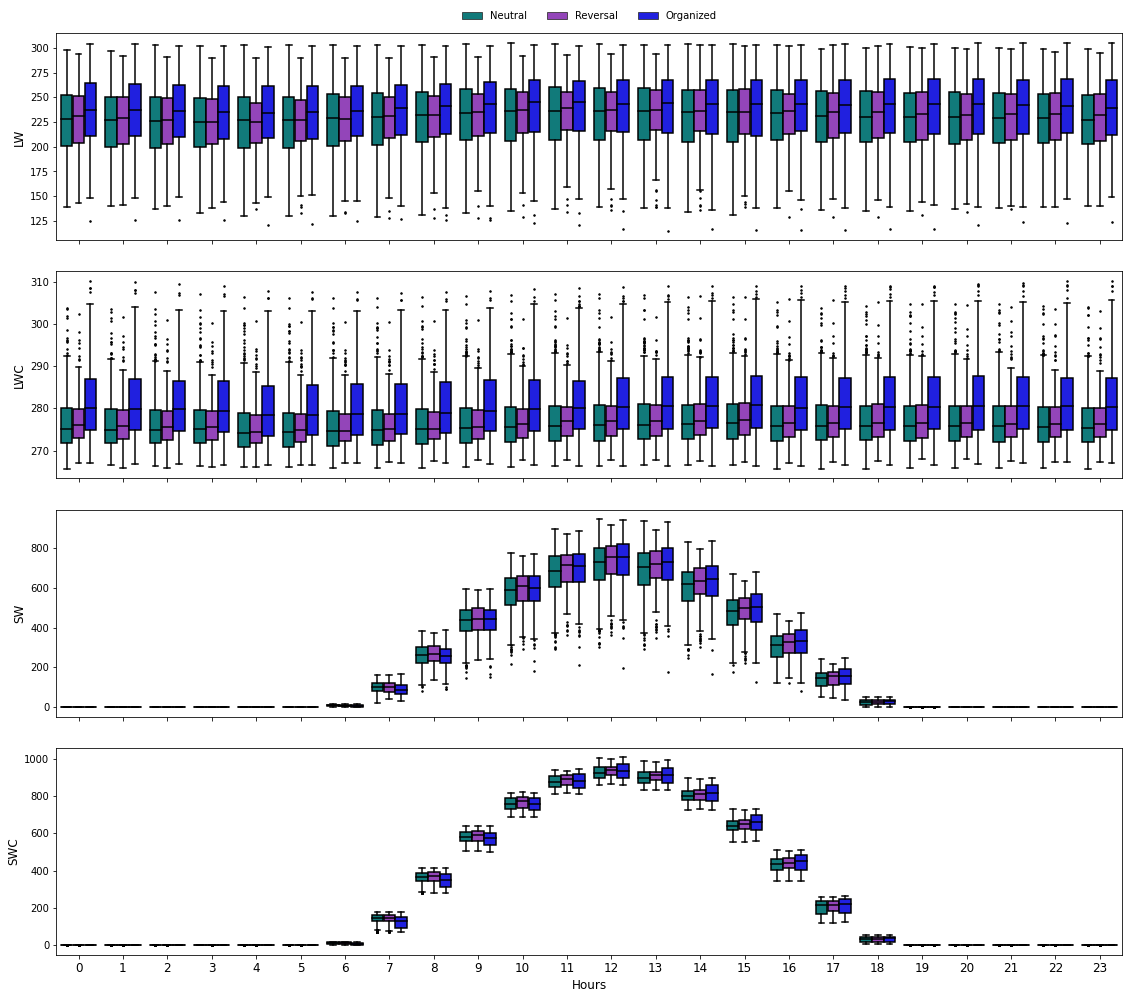

In [66]:
varis = ['LW','LWC','SW','SWC']
titles = ['LW','LWC','SW','SWC']

fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(4,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.hour, y='Value', hue='Conditions', 
                     palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,24), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Hours', fontsize = 12)
    plt.ylabel(titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)

plt.savefig(path+'box_per_hour_radiation_ne.jpg', bbox_inches='tight')

plt.show()

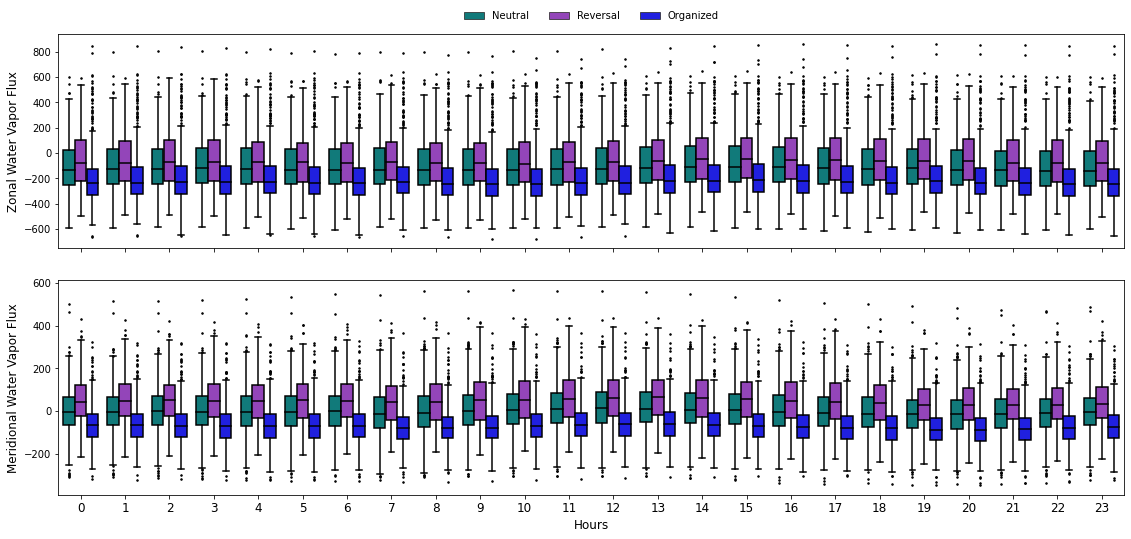

In [67]:
varis = ['WVF U','WVF V']
titles = ['Zonal Water Vapor Flux','Meridional Water Vapor Flux']

fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.hour, y='Value', hue='Conditions', palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,24), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Hours', fontsize = 12)
    plt.ylabel(titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)
        
plt.savefig(path+'box_per_hour_all_WVF_ne.jpg', bbox_inches='tight')

plt.show()

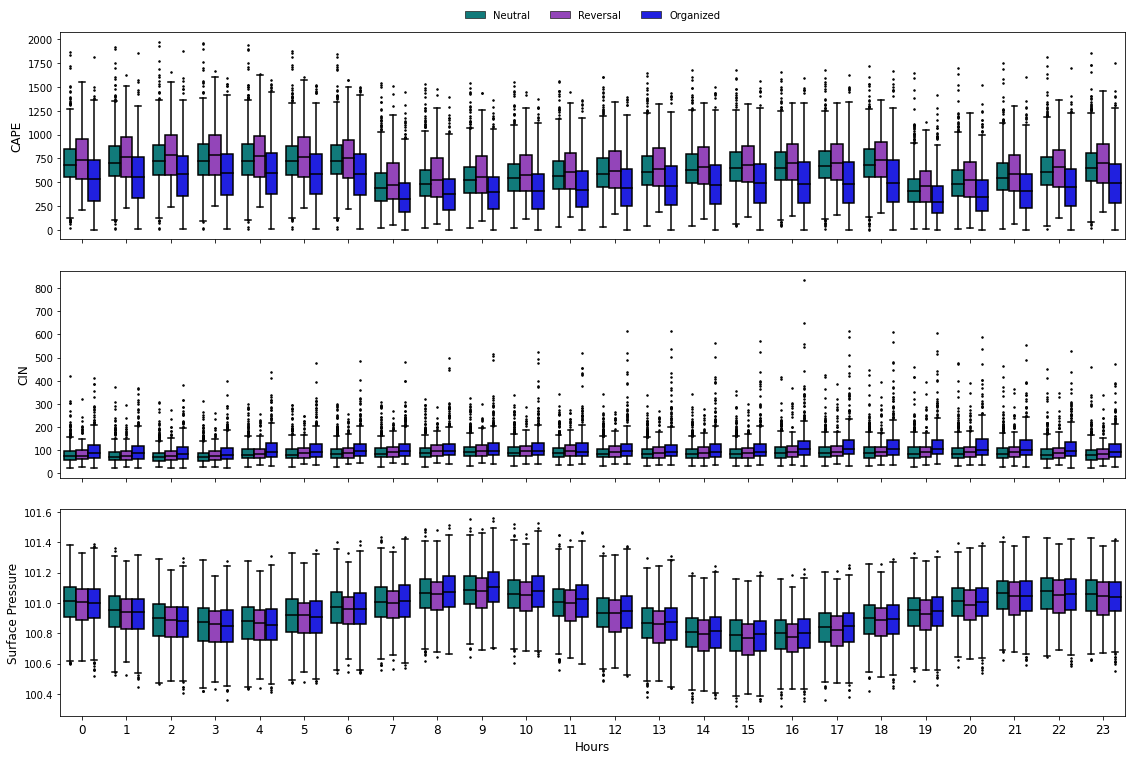

In [68]:
varis = ['CAPE','CIN','Press']
titles = ['CAPE','CIN','Surface Pressure']

fig = plt.figure(figsize=(16,16))
gs = gridspec.GridSpec(4,1, left=0.05, right=0.975, hspace=0.15, wspace=0.2, top=0.9, bottom=0.1)

for i,var in enumerate(varis):
    df = boxplot_data(var)
    ax=subplot(gs[i])
    bp = sns.boxplot(data = df, x=df.index.hour, y='Value', hue='Conditions', palette=['darkcyan','darkorchid','b'],
                     flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                     boxprops = dict(edgecolor='black'),
                     medianprops = dict(color = 'black'),
                     whiskerprops = dict(color = 'black'),
                     capprops = dict(color = 'black')
                    )

    plt.xticks(np.arange(0,24), fontsize = 12)
    if i != len(varis)-1:
        ax.xaxis.set_major_formatter(NullFormatter())
        plt.xlabel('')
    else:
        plt.xlabel('Hours', fontsize = 12)
    plt.ylabel(titles[i], fontsize = 12)
    if i == 0:
        plt.legend(frameon=False, ncol=3, bbox_to_anchor=(0.5, 1.15), loc ='upper center')
    else:
        plt.legend('', frameon = False)
        
plt.savefig(path+'box_per_hour_all_CAPE_Press_ne.jpg', bbox_inches='tight')

plt.show()

### Shear

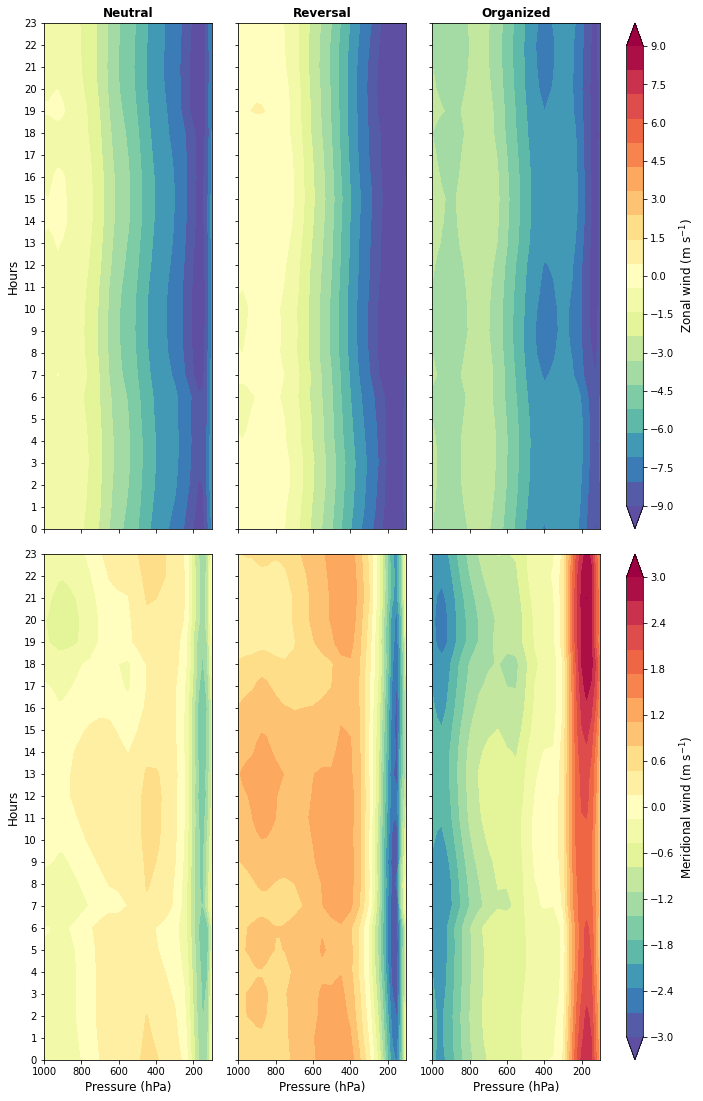

In [69]:
varis = [np.array(hour_ne_met[zonally]), np.array(hour_lo_met[zonally]), 
         np.array(hour_hi_met[zonally]), np.array(hour_ne_met[meridionally]), 
         np.array(hour_lo_met[meridionally]), np.array(hour_hi_met[meridionally])]
titles = ['Neutral', 'Reversal', 'Organized']
levels = [np.linspace(-9,9,20),np.linspace(-9,9,20),np.linspace(-9,9,20),
         np.linspace(-3,3,20),np.linspace(-3,3,20),np.linspace(-3,3,20)]

fig = plt.figure(figsize=(9,18))
gs = gridspec.GridSpec(2,4, left=0.05, right=0.975, hspace=0.05, wspace=0.2, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,1,0.1])

for i,var in enumerate(varis):
    if i < 3:
        ax=subplot(gs[i])
        im = plt.contourf(pressure, np.arange(0,24), var, cmap = 'Spectral_r', 
                      levels = levels[i], extend = 'both')
    else:
        ax=subplot(gs[i+1])
        im1 = plt.contourf(pressure, np.arange(0,24), var, cmap = 'Spectral_r', 
                      levels = levels[i], extend = 'both')
    if i < 3:
        plt.title(titles[i], fontweight = 'bold')
        ax.xaxis.set_major_formatter(NullFormatter())
    else:
        plt.xlabel('Pressure (hPa)', fontsize  = 12)
    plt.yticks(np.arange(0,24))
    plt.xlim(1000,100)
    if i == 0 or i == 3:
        plt.ylabel('Hours', fontsize  = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
    
cax = plt.subplot(gs[3])
bar = plt.colorbar(im, orientation='vertical', cax=cax, ticks=np.arange(-9,10,1.5))
bar.set_label('Zonal wind (m s$^{-1}$)', fontsize  = 12)

cax = plt.subplot(gs[7])
bar1 = plt.colorbar(im1, orientation='vertical', cax=cax, ticks=np.arange(-3,3.1,0.6))
bar1.set_label('Meridional wind (m s$^{-1}$)', fontsize  = 12)

plt.savefig(path+'hov_per_hour_shear_ne.jpg', bbox_inches='tight')


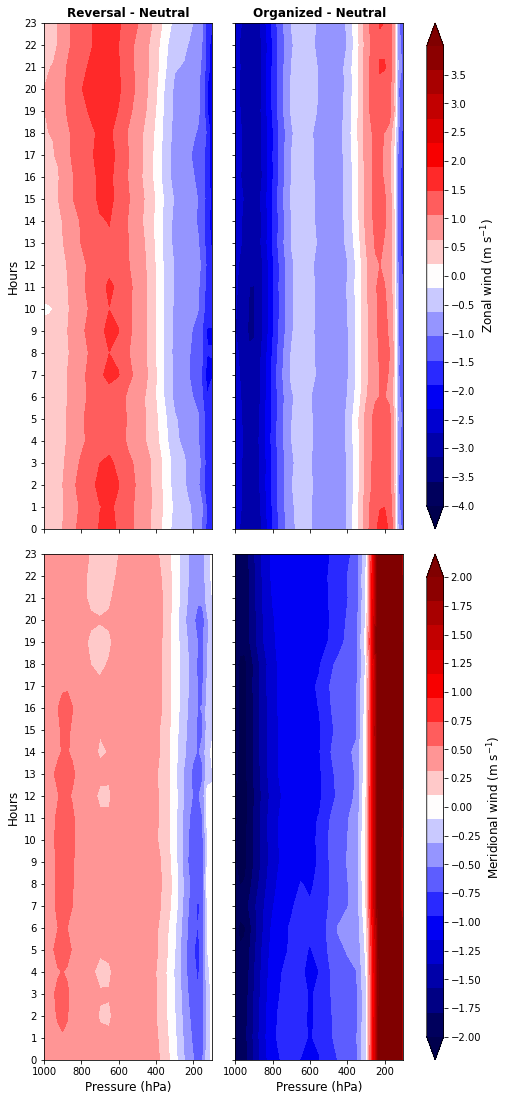

In [70]:
varis = [np.array(hour_lo_met[zonally])-np.array(hour_ne_met[zonally]), 
         np.array(hour_hi_met[zonally])-np.array(hour_ne_met[zonally]),
         np.array(hour_lo_met[meridionally])-np.array(hour_ne_met[meridionally]), 
         np.array(hour_hi_met[meridionally])-np.array(hour_ne_met[meridionally])]
titles = ['Reversal - Neutral', 'Organized - Neutral']
levels = [np.linspace(-4,4,20),np.linspace(-4,4,20),np.linspace(-4,4,20),
         np.linspace(-2,2,20),np.linspace(-2,2,20),np.linspace(-2,2,20)]

fig = plt.figure(figsize=(6,18))
gs = gridspec.GridSpec(2,3, left=0.05, right=0.975, hspace=0.05, wspace=0.2, top=0.9, bottom=0.1, 
                       width_ratios=[1,1,0.1])

for i,var in enumerate(varis):
    if i < 2:
        ax=subplot(gs[i])
        im = plt.contourf(pressure, np.arange(0,24), var, cmap = 'seismic', 
                          levels = levels[i], extend = 'both')
    else:
        ax=subplot(gs[i+1])
        im1 = plt.contourf(pressure, np.arange(0,24), var, cmap = 'seismic', 
                          levels = levels[i], extend = 'both')
    if i < 2:
        plt.title(titles[i], fontweight = 'bold')
        ax.xaxis.set_major_formatter(NullFormatter())
    else:
        plt.xlabel('Pressure (hPa)', fontsize  = 12)
    plt.yticks(np.arange(0,24))
    plt.xlim(1000,100)
    if i == 0 or i == 2:
        plt.ylabel('Hours', fontsize  = 12)
    else:
        ax.yaxis.set_major_formatter(NullFormatter())
    
cax = plt.subplot(gs[2])
bar = plt.colorbar(im, orientation='vertical', cax=cax, ticks=np.arange(-4,4,0.5))
bar.set_label('Zonal wind (m s$^{-1}$)', fontsize  = 12)

cax = plt.subplot(gs[5])
bar1 = plt.colorbar(im1, orientation='vertical', cax=cax, ticks=np.arange(-2,2.1,0.25))
bar1.set_label('Meridional wind (m s$^{-1}$)', fontsize  = 12)

plt.savefig(path+'hov_per_hour_shear_anom_ne.jpg', bbox_inches='tight')


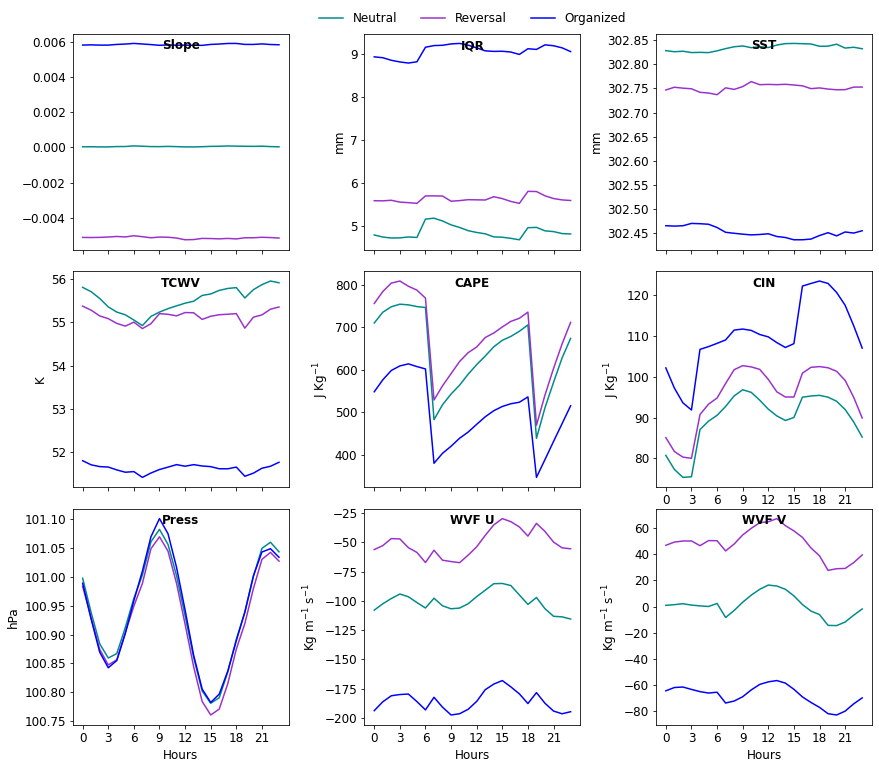

In [71]:
all_vars = ['Slope', 'IQR', 'SST', 'TCWV', 'CAPE', 'CIN', 'Press', 'WVF U', 'WVF V']
units = ['', 'mm', 'mm', 'K','J Kg$^{-1}$','J Kg$^{-1}$','hPa',
         'Kg m$^{-1}$ s$^{-1}$', 'Kg m$^{-1}$ s$^{-1}$']

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3,3, left=0.05, right=0.975, hspace=0.1, wspace=0.35, top=0.9, bottom=0.1)

x = np.arange(0,24)

for i,var in enumerate(all_vars):
    ax=subplot(gs[i])
    if i == 0:
        plt.plot(x,hour_ne_slo[var], color = 'darkcyan', label = 'Neutral')
        plt.plot(x,hour_lo_slo[var], color = 'darkorchid', label = 'Reversal')
        plt.plot(x,hour_hi_slo[var], color = 'blue', label = 'Organized')
    else:
        plt.plot(x,hour_ne_met[var], color = 'darkcyan', label = 'Neutral')
        plt.plot(x,hour_lo_met[var], color = 'darkorchid', label = 'Reversal')
        plt.plot(x,hour_hi_met[var], color = 'blue', label = 'Organized')
    plt.title(all_vars[i], y = 0.9, fontweight = 'bold')
    plt.yticks(fontsize = 12)
    plt.xticks(np.arange(0,24,3),fontsize = 12)
    plt.ylabel(units[i], fontsize = 12)
    if i == 1:
        plt.legend(bbox_to_anchor=(0.5,1.15), loc = 'upper center', ncol = 3, 
                   frameon = False, fontsize = 12)
    if i < 5:
        ax.xaxis.set_major_formatter(NullFormatter())
    else:
        plt.xlabel('Hours', fontsize = 12)
        
plt.savefig(path+'hourly_mean_met_data_ne.jpg', bbox_inches='tight')

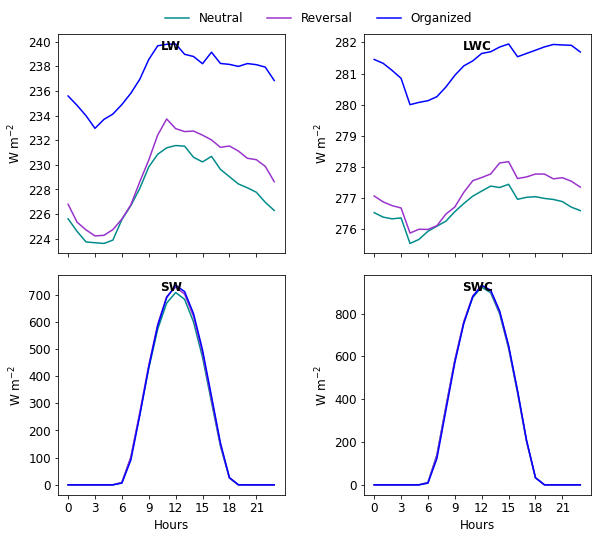

In [72]:
all_vars = ['LW', 'LWC', 'SW', 'SWC']
units = ['W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$']

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2,2, left=0.05, right=0.975, hspace=0.1, wspace=0.35, top=0.9, bottom=0.1)

x = np.arange(0,24)

for i,var in enumerate(all_vars):
    ax=subplot(gs[i])
    plt.plot(x,hour_ne_met[var], color = 'darkcyan', label = 'Neutral')
    plt.plot(x,hour_lo_met[var], color = 'darkorchid', label = 'Reversal')
    plt.plot(x,hour_hi_met[var], color = 'blue', label = 'Organized')
    plt.title(all_vars[i], y = 0.9, fontweight = 'bold')
    plt.yticks(fontsize = 12)
    plt.xticks(np.arange(0,24,3),fontsize = 12)
    plt.ylabel(units[i], fontsize = 12)
    if i == 0:
        plt.legend(bbox_to_anchor=(1.15,1.15), loc = 'upper center', ncol = 3, 
                   frameon = False, fontsize = 12)
    if i < 2:
        ax.xaxis.set_major_formatter(NullFormatter())
    else:
        plt.xlabel('Hours', fontsize = 12)

plt.savefig(path+'hourly_mean_rad_data_ne.jpg', bbox_inches='tight')

## Slopes

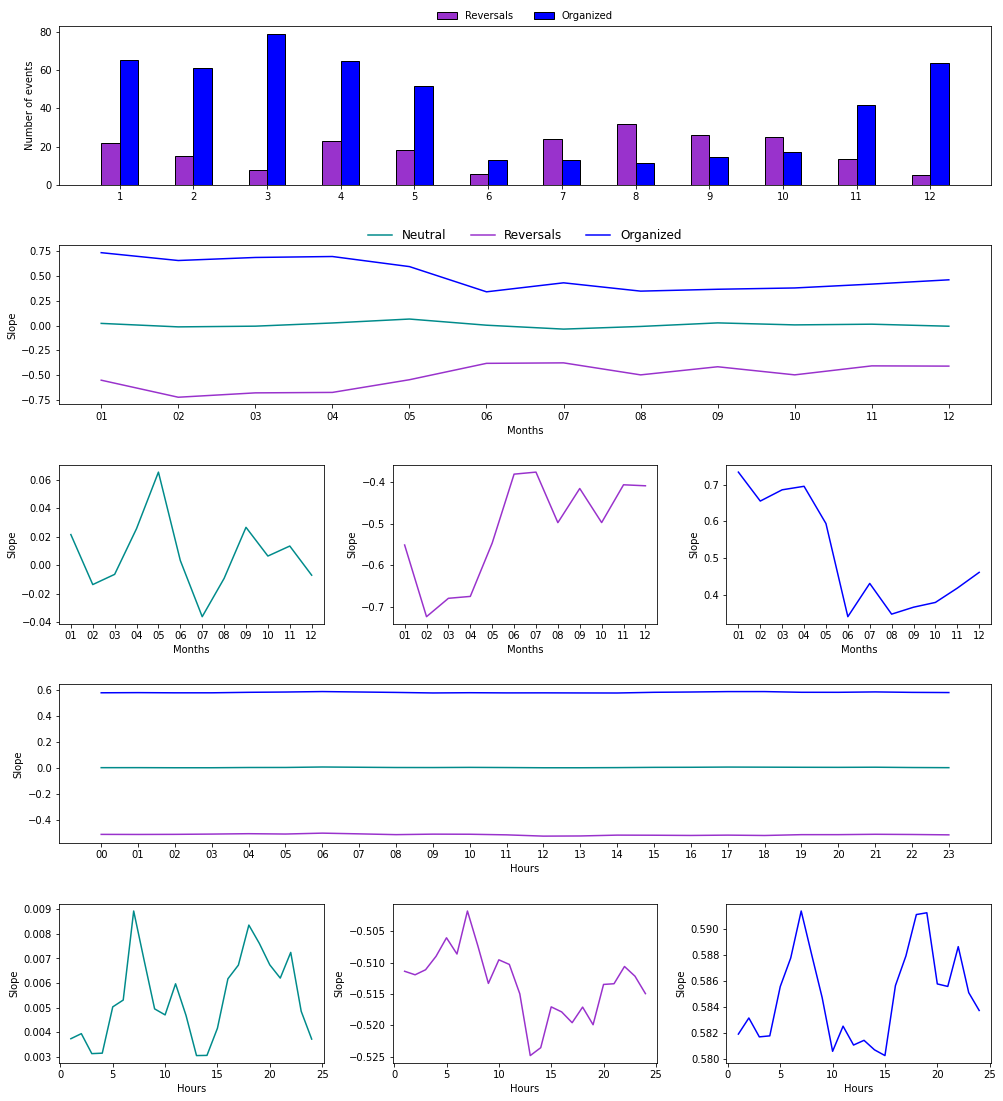

In [73]:
factor = 100
fig = plt.figure(figsize=(14,18))
gs = gridspec.GridSpec(5,3, left=0.05, right=0.975, hspace=0.38, wspace=0.26, top=0.9, bottom=0.1)

ax=subplot(gs[0,:])
plt.bar(np.arange(1,13)-width/2, msize_lo_slo, edgecolor = 'k', 
        color = 'darkorchid', label = 'Reversals', width = width)
plt.bar(np.arange(1,13)+width/2, msize_hi_slo, edgecolor = 'k', 
        color = 'blue', label = 'Organized', width = width)
plt.legend(bbox_to_anchor=(0.5,1.15), loc = 'upper center', ncol = 2, frameon = False)
plt.xticks(np.arange(1,13))
plt.ylabel('Number of events')

ax=subplot(gs[1,:])
plt.plot(month_ne_slo*factor, color = 'darkcyan', label = 'Neutral')
plt.plot(month_lo_slo*factor, color = 'darkorchid', label = 'Reversals')
plt.plot(month_hi_slo*factor, color = 'blue', label = 'Organized')
plt.legend(bbox_to_anchor=(0.5,1.17), loc = 'upper center', ncol = 3, frameon = False, fontsize = 12)
plt.ylabel('Slope')
plt.xlabel('Months')

ax=subplot(gs[2,0])
plt.plot(month_ne_slo*factor, color = 'darkcyan', label = 'Mean')
plt.ylabel('Slope')
plt.xlabel('Months')

ax=subplot(gs[2,1])
plt.plot(month_lo_slo*factor, color = 'darkorchid', label = 'Reversals')
plt.ylabel('Slope')
plt.xlabel('Months')

ax=subplot(gs[2,2])
plt.plot(month_hi_slo*factor, color = 'blue', label = 'Organized')
plt.ylabel('Slope')
plt.xlabel('Months')

ax=subplot(gs[3,:])
plt.plot(hour_ne_slo*factor, color = 'darkcyan', label = 'Neutral')
plt.plot(hour_lo_slo*factor, color = 'darkorchid', label = 'Reversals')
plt.plot(hour_hi_slo*factor, color = 'blue', label = 'Organized')
plt.ylabel('Slope')
plt.xlabel('Hours')

ax=subplot(gs[4,0])
plt.plot(np.arange(1,25),hour_ne_slo*factor, color = 'darkcyan', label = 'Mean')
plt.ylabel('Slope')
plt.xlabel('Hours')

ax=subplot(gs[4,1])
plt.plot(np.arange(1,25),hour_lo_slo*factor, color = 'darkorchid', label = 'Reversals')
plt.ylabel('Slope')
plt.xlabel('Hours')

ax=subplot(gs[4,2])
plt.plot(np.arange(1,25),hour_hi_slo*factor, color = 'blue', label = 'Organized')
plt.ylabel('Slope')
plt.xlabel('Hours')

plt.savefig(path+'Frequency_slope_hourly_ne.jpg', bbox_inches = 'tight')
plt.show()

In [74]:
### Sizes
msize_lo_slo = daymean_slo.groupby(daymean_slo.index.strftime('%m')).size()
msize_hi_slo = daymean_shi.groupby(daymean_shi.index.strftime('%m')).size()

count_lo_slo = daymean_slo.resample('M').count()
count_lo_slo = np.array(count_lo_slo['Slope'])
count_lo_shi = daymean_shi.resample('M').count()
count_lo_shi = np.array(count_lo_shi['Slope'])
while len(count_lo_slo) != 48:
    count_lo_slo = np.append(count_lo_slo, 0)
while len(count_lo_shi) != 48:   
    count_lo_shi = np.append(count_lo_shi, 0)

xaxis = ['1','2','3','4','5','6','7','8','9','10','11','12',
         '1','2','3','4','5','6','7','8','9','10','11','12',
         '1','2','3','4','5','6','7','8','9','10','11','12',
         '1','2','3','4','5','6','7','8','9','10','11','12']

Text(0.5, 0, 'Month')

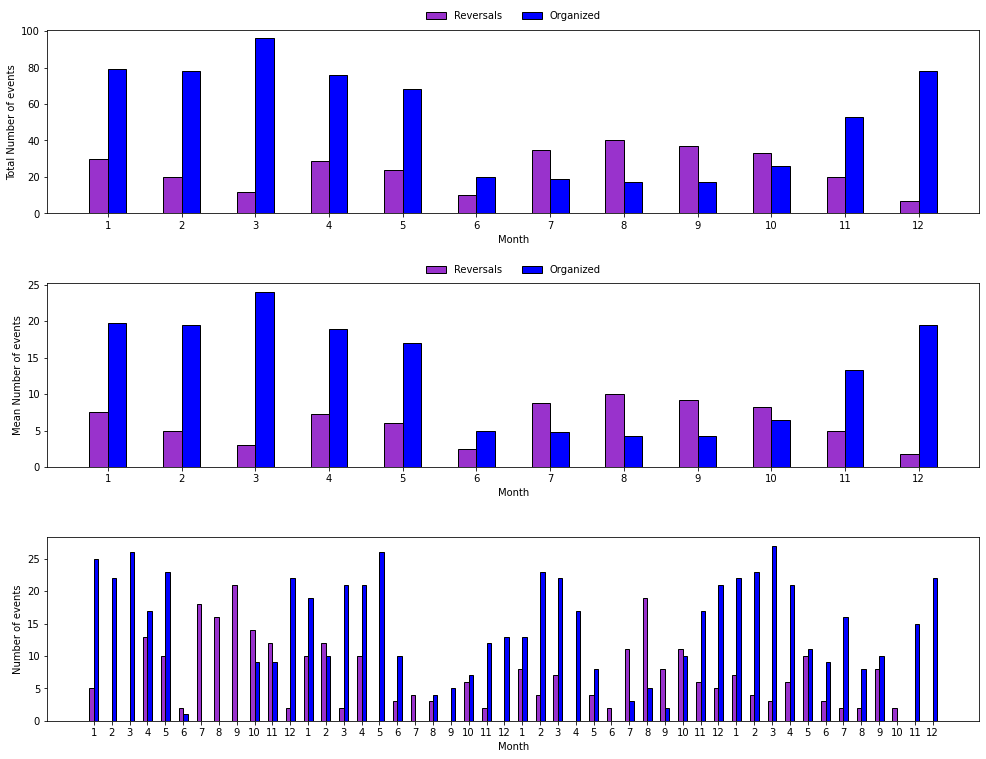

In [75]:
fig = plt.figure(figsize=(14,12))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.38, wspace=0.26, top=0.9, bottom=0.1)

ax=subplot(gs[0])
plt.bar(np.arange(1,13)-width/2, msize_lo_slo, edgecolor = 'k', 
        color = 'darkorchid', label = 'Reversals', width = width)
plt.bar(np.arange(1,13)+width/2, msize_hi_slo, edgecolor = 'k', 
        color = 'blue', label = 'Organized', width = width)
plt.legend(bbox_to_anchor=(0.5,1.15), loc = 'upper center', ncol = 2, frameon = False)
plt.xticks(np.arange(1,13))
plt.ylabel('Total Number of events')
plt.xlabel('Month')

ax=subplot(gs[1])
plt.bar(np.arange(1,13)-width/2, msize_lo_slo/4, edgecolor = 'k', 
        color = 'darkorchid', label = 'Reversals', width = width)
plt.bar(np.arange(1,13)+width/2, msize_hi_slo/4, edgecolor = 'k', 
        color = 'blue', label = 'Organized', width = width)
plt.legend(bbox_to_anchor=(0.5,1.15), loc = 'upper center', ncol = 2, frameon = False)
plt.xticks(np.arange(1,13))
plt.ylabel('Mean Number of events')
plt.xlabel('Month')

ax=subplot(gs[2])
plt.bar(np.arange(1,49)-width/2, count_lo_slo, edgecolor = 'k', 
        color = 'darkorchid', label = 'Reversals', width = width)
plt.bar(np.arange(1,49)+width/2, count_lo_shi, edgecolor = 'k', 
        color = 'blue', label = 'Organized', width = width)
plt.xticks(np.arange(1,49), xaxis)
plt.ylabel('Number of events')
plt.xlabel('Month')

## Spearman

In [76]:
spea_t, ps_t = spe_corr(slopes, met_data)
spea_lo, ps_lo = spe_corr(df_slop_lo, met_lo_data)
spea_hi, ps_hi = spe_corr(df_slop_hi, met_hi_data)

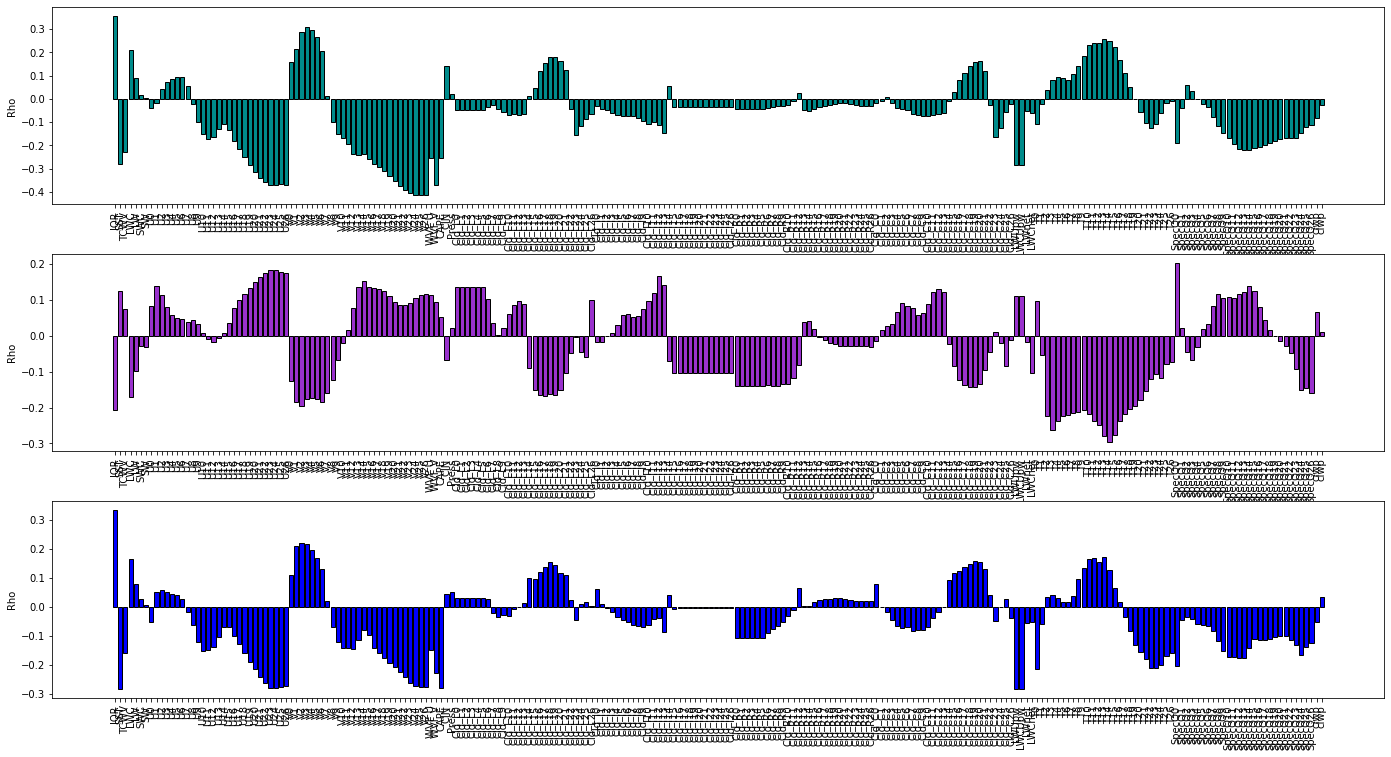

In [77]:
plt.figure(figsize = (20,12))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.25, wspace=0.26, top=0.9, bottom=0.1)
ax=subplot(gs[0])
plt.bar(met_data.columns,spea_t, edgecolor = 'k', color = 'darkcyan')
plt.ylabel('Rho')
plt.xticks(rotation = 90)

ax=subplot(gs[1])
plt.bar(met_data.columns,spea_lo, edgecolor = 'k', color = 'darkorchid')
plt.ylabel('Rho')
plt.xticks(rotation = 90)

ax=subplot(gs[2])
plt.bar(met_data.columns,spea_hi, edgecolor = 'k', color = 'blue')
plt.ylabel('Rho')
plt.xticks(rotation = 90)
plt.show()